# MBA em Data Science and Analytics
## Trabalho de conclusão de curso (TCC)
Autor: **Renato Fernandes de Souza** <br>
Orientador: **Nuno Manoel Martins Dias Fouto** <br>
Ano: **2022**
### Utilização do Preço da Liquidação das Diferenças horário na predição de geração eólica
1. Construção da curva de potência com base nos dados de geração reais passados
2. Predição da velocidade do vento através da análise de séries temporais
3. Predição da geração de energia, relacionando a velocidade do vento predita e a curva de potência
4. Predição da exposição horária, relacionando a energia predita e o PLD horário do dia seguinte

# Importação de pacotes

In [54]:
import pandas as pd
import seaborn as sns
import datetime as dt
import boto3
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import kstest_normal

from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr

from scipy import stats

mpl.rcParams["text.usetex"] = False

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# referencias
# https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting/notebook

# Carregamento da base de dados

In [3]:
df_original = pd.read_csv("D:\\OneDrive\\Faculdade\\MBA\TCC\\Datasets\\archive\\T1.csv", sep=',')

In [4]:
df_pld = pd.read_parquet("C:\\Users\\renat\\Downloads\\2018-11.parquet")
df_pld.Data.min()

Timestamp('2018-11-01 00:00:00')

# previsualizando dataset

In [5]:
df_original.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [6]:
df_dtypes = pd.DataFrame(df_original.dtypes).reset_index().rename(columns={'index': 'Coluna', 0: 'Tipo de dados'})
df_dtypes['Descrição'] = ['Data e hora da observação', 'Potência ativa de saída do aerogerador', 
                          'Velocidade do vento medida no aerogerador', 'Potência ativa de saída teórica',
                          'Direção do vento']
df_styler = df_dtypes.style.set_properties(**{'text-align': 'left'})
df_styler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
#df_dtypes

,Coluna,Tipo de dados,Descrição
0,Date/Time,object,Data e hora da observação
1,LV ActivePower (kW),float64,Potência ativa de saída do aerogerador
2,Wind Speed (m/s),float64,Velocidade do vento medida no aerogerador
3,Theoretical_Power_Curve (KWh),float64,Potência ativa de saída teórica
4,Wind Direction (°),float64,Direção do vento


In [7]:
df_original.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [8]:
# null values wind speed
df_original['Wind Speed (m/s)'].isna().sum()

0

In [9]:
# null values wind speed
df_original['LV ActivePower (kW)'].isna().sum()

0

# Formatando dataset

In [95]:
df = df_original.copy()
df['datetime'] = pd.to_datetime(df['Date/Time'])
df['power'] = df['LV ActivePower (kW)']
df['windspeed'] = df['Wind Speed (m/s)']
df.drop(columns=['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
        inplace=True)
df.dtypes

datetime     datetime64[ns]
power               float64
windspeed           float64
dtype: object

In [96]:
df = df.round(2)

In [98]:
#start_dt = dt.datetime(2018,10,1)
#df = df[df['datetime'] >= start_dt]
df[df['datetime'] >= start_dt].head()

,datetime,power,windspeed
1275,2018-10-01 00:00:00,472.520,5.590
1276,2018-10-01 00:10:00,492.110,5.950
1277,2018-10-01 00:20:00,270.480,4.750
1278,2018-10-01 00:30:00,355.230,5.260
1279,2018-10-01 00:40:00,288.440,4.870


In [99]:
df.set_index('datetime', inplace=True)
df.head()

,power,windspeed
datetime,,
2018-01-01 00:00:00,380.050,5.310
2018-01-01 00:10:00,453.770,5.670
2018-01-01 00:20:00,306.380,5.220
2018-01-01 00:30:00,419.650,5.660
2018-01-01 00:40:00,380.650,5.580


# Análise descritiva

[Text(0.5, 1.0, 'Distribuição da velocidade do vento')]

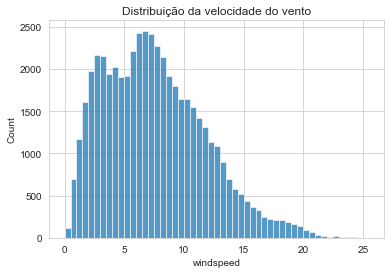

In [100]:
sns.set_style("whitegrid")
sns.histplot(df['windspeed'], binwidth=0.5).set(title='Distribuição da velocidade do vento')

In [101]:
# weibull distribution
arrWind = df['windspeed'].values
try:
    k_weibull = np.power(arrWind.std() / arrWind.mean(), -1.086)
except ZeroDivisionError:
    k_weibull = 2  # distribuição de rayleigh (default)
try:
    c_weibull = arrWind.mean() / math.gamma(1 + (1 / k_weibull))
except ZeroDivisionError:
    c_weibull = 1
dx = 0.5
bins = np.arange(0, 25, dx)

def f_weibull(v, k, c):
    return (k / c) * np.power((v / c), k - 1) * np.exp(-np.power(v / c, k))

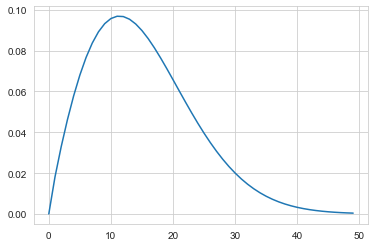

weibull parameters: k=1.88, c=8.51


In [102]:
plt.plot(f_weibull(bins, k_weibull, c_weibull))
plt.show()
print(f'weibull parameters: k={round(k_weibull, 2)}, c={round(c_weibull, 2)}')

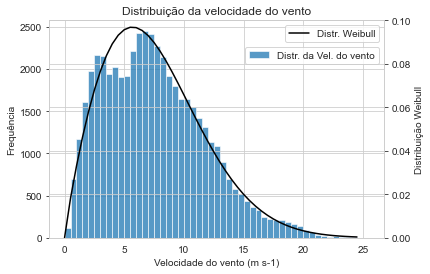

In [103]:
df_weibull = pd.DataFrame({'weibull':f_weibull(bins, k_weibull, c_weibull), 'bins': bins})

fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 
plt.ylim(0, 0.1)

sns.histplot(df['windspeed'], binwidth=0.5, ax=ax1, label='Distr. da Vel. do vento').set(title='Distribuição da velocidade do vento')
sns.lineplot(data=df_weibull, x='bins', y='weibull', ax=ax2, color='black', label='Distr. Weibull')

ax1.set_xlabel('Velocidade do vento (m s-1)')
ax1.set_ylabel('Frequência')
ax2.set_ylabel('Distribuição Weibull')
ax1.set_title('Distribuição da velocidade do vento')
ax1.legend(loc=(0.585, 0.8))
#df_weibull

In [104]:
# teste de aderência à distribuição weibull
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html#scipy.stats.weibull_min

# stats.kstest(df['windspeed'], stats.weibull_min.pdf(df['windspeed'], 1.88))

# KS test for goodness of fit: p-value > 0.05 =
# https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
params = stats.weibull_min.fit(df['windspeed']/np.max(np.histogram(df['windspeed'])[0]))

print(f'params {params}')
print(stats.kstest(df['windspeed'], stats.weibull_min.name, params))

#rv = stats.weibull_min(c=1.88, loc=0, scale=8.51)
#data = rv.rvs(1000)
#plt.hist(data)
print(np.histogram(df['windspeed'])[0])

params (0.24315334578710585, -2.9388820822320783e-29, 0.07234229247089066)
KstestResult(statistic=0.8381939060906551, pvalue=0.0)
[ 5697 10198 11581  9714  7045  3629  1539   885   202    40]


In [21]:
# KS test for goodness of fit
distributions = [
    stats.norm, stats.beta, stats.expon, stats.gamma, stats.genextreme, stats.logistic, stats.lognorm, stats.triang, stats.uniform, stats.fatiguelife, 
    stats.gengamma, stats.gennorm, stats.dweibull, stats.dgamma, stats.gumbel_r, stats.powernorm, stats.rayleigh, stats.weibull_max, stats.weibull_min,
    stats.laplace, stats.alpha, stats.genexpon, stats.bradford, stats.betaprime, stats.burr, stats.fisk, stats.genpareto, stats.hypsecant,
    stats.halfnorm, stats.halflogistic, stats.invgauss, stats.invgamma, stats.levy, stats.loglaplace, stats.loggamma, stats.maxwell,
    stats.mielke, stats.ncx2, stats.ncf, stats.nct, stats.nakagami, stats.pareto, stats.lomax, stats.powerlognorm, stats.powerlaw, stats.rice,
    stats.semicircular, stats.trapezoid, stats.rice, stats.invweibull, stats.foldnorm, stats.foldcauchy, stats.cosine, stats.exponpow,
    stats.exponweib, stats.wald, stats.wrapcauchy, stats.truncexpon, stats.truncnorm, stats.t, stats.rdist
    ]


def kstest(data, distname, paramtup):
    ks = stats.kstest(data, distname, paramtup)[1]   # return p-value
    return ks             # return p-value

# distribution fitter and call to KS test

def fitdist(data, dist):    
    fitted = dist.fit(data)
    ks = kstest(data, dist.name, fitted)
    res = (dist.name, ks, *fitted)
    return res

# call fitting function for all distributions in list
#res = [fitdist(df['windspeed'],D) for D in distributions]
res = [fitdist((df['windspeed'] - np.mean(df['windspeed']))/(np.std(df['windspeed'])),D) for D in distributions]

# convert the fitted list of tuples to dataframe
pd.options.display.float_format = '{:,.3f}'.format
dft = pd.DataFrame(res, columns=["distribution", "KS p-value", "param1", "param2", "param3", "param4", "param5"])
dft["distobj"] = distributions
dft.sort_values(by=["KS p-value"], inplace=True, ascending=False)
dft.reset_index(inplace=True)
dft.drop("index", axis=1, inplace=True)
dft

D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\scipy\stats\_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\scipy\stats\_continuous_distns.py:809: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\scipy\stats\_continuous_distns.py:813: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\scipy\stats\_continuous_distns.py:5350: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\scipy\stats\_continuous_distns.py:6432: RuntimeWarning: overflow encountered in exp
  Px = np.exp(trm1)
D:\OneDrive\Trabalho\Ambientes Python\Pyth

,distribution,KS p-value,param1,param2,param3,param4,param5,distobj
0,gengamma,0.000,0.671,2.406,-1.806,2.545,NaN,<scipy.stats._continuous_distns.gengamma_gen o...
1,foldnorm,0.000,1.604,-1.805,1.092,NaN,NaN,<scipy.stats._continuous_distns.foldnorm_gen o...
2,weibull_min,0.000,1.867,-1.809,2.036,NaN,NaN,<scipy.stats._continuous_distns.weibull_min_ge...
3,nakagami,0.000,0.880,-1.806,2.065,NaN,NaN,<scipy.stats._continuous_distns.nakagami_gen o...
4,beta,0.000,1.922,4.261,-1.807,5.811,NaN,<scipy.stats._continuous_distns.beta_gen objec...
...,...,...,...,...,...,...,...,...
56,mielke,0.000,1.135,1.342,-1.805,1.036,NaN,<scipy.stats._continuous_distns.mielke_gen obj...
57,powernorm,0.000,0.000,-1.860,0.015,NaN,NaN,<scipy.stats._continuous_distns.powernorm_gen ...
58,levy,0.000,-1.816,1.096,NaN,NaN,NaN,<scipy.stats._continuous_distns.levy_gen objec...
59,burr,0.000,1.388,0.700,-1.805,1.999,NaN,<scipy.stats._continuous_distns.burr_gen objec...


Text(0, 0.5, 'Frequência')

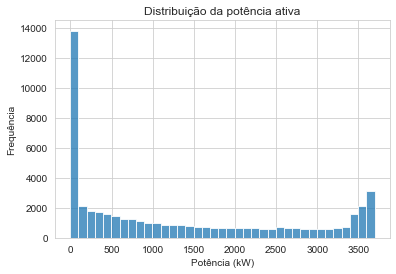

In [105]:
sns.histplot(df['power'], binwidth=100).set(title='Distribuição da potência ativa')
plt.xlabel('Potência (kW)')
plt.ylabel('Frequência')

In [106]:
correlation_matrix = df.corr()
correlation_matrix

,power,windspeed
power,1.000,0.913
windspeed,0.913,1.000


<AxesSubplot:>

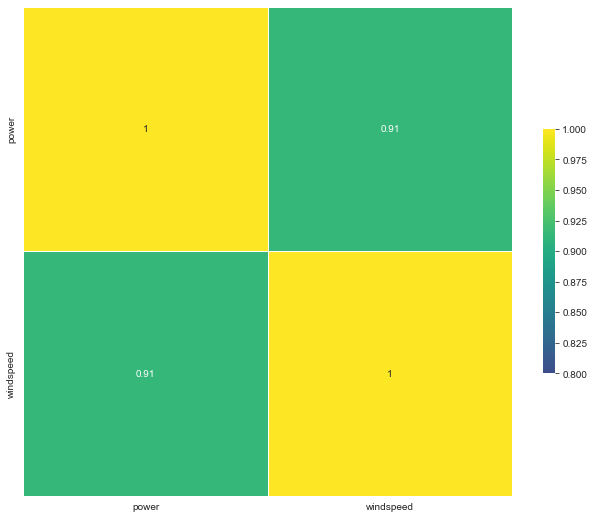

In [107]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, vmin=0.8, vmax=1.0, center=0.87, cmap="viridis", annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:xlabel='windspeed', ylabel='power'>

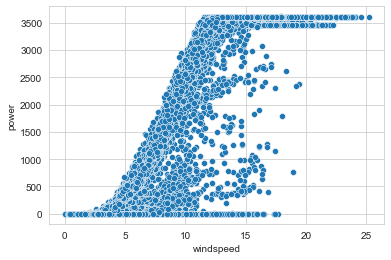

In [108]:
# potência em função da velocidade do vento
sns.scatterplot(data=df, x='windspeed', y='power')

<AxesSubplot:xlabel='datetime', ylabel='windspeed'>

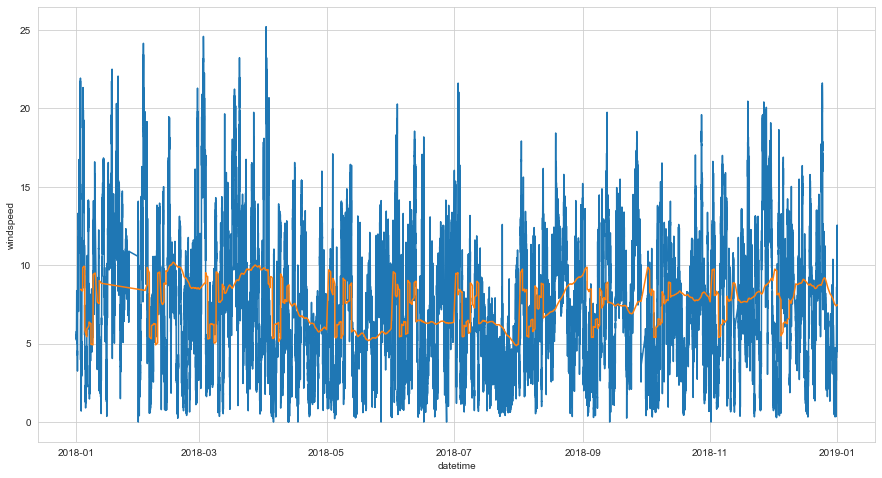

In [109]:
# visualização dos dados ao longo do tempo
plt.figure(figsize=(15,8))
sns.lineplot(data=df['windspeed'])
sns.lineplot(data=df['windspeed'].rolling(6 * 24 * 30).mean())

<AxesSubplot:xlabel='datetime', ylabel='power'>

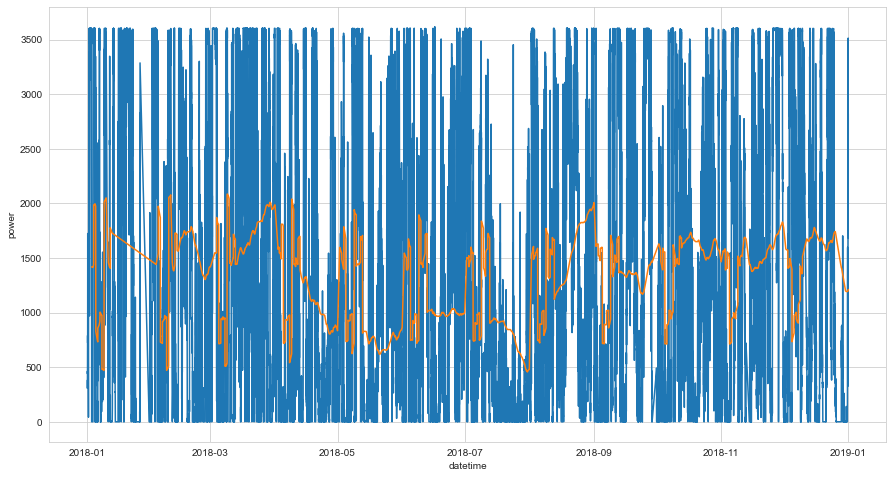

In [110]:
# visualização dos dados ao longo do tempo
plt.figure(figsize=(15,8))
sns.lineplot(data=df['power'])
sns.lineplot(data=df['power'].rolling(6 * 24 * 30).mean())

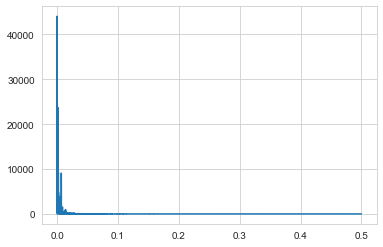

In [111]:
# seasonality with sarima model
from scipy import signal
f, Pxx = signal.periodogram(df['windspeed'])
plt.plot(f, Pxx)

In [112]:
top_3_periods = {}

# get indices for 3 highest Pxx values
top3_freq_indices = np.flip(np.argsort(Pxx), 0)[0:4]

# use indices from previous step to
# get 3 frequencies with highest power
freqs = f[top3_freq_indices]

# use same indices to get powers as well
power = Pxx[top3_freq_indices]

# we are interested in period and it is calculated as 1/frequency 
periods = 1 / np.array(freqs)

# populate dict with calculated values
top_3_periods['period1'] = periods[0]
top_3_periods['freq1'] = freqs[0]
top_3_periods['power1'] = power[0]

top_3_periods['period2'] = periods[1]
top_3_periods['freq2'] = freqs[1]
top_3_periods['power2'] = power[1]

top_3_periods['period3'] = periods[2]
top_3_periods['freq3'] = freqs[2]
top_3_periods['power3'] = power[2]

top_3_periods['period4'] = periods[3]
top_3_periods['freq4'] = freqs[3]
top_3_periods['power4'] = power[3]
top_3_periods

# sazonalidades:
# anual
# a cada 2 meses
# mensal
# a cada 4..5 dias (semanal)

{'period1': 50530.0,
 'freq1': 1.9790223629527014e-05,
 'power1': 44055.10601309342,
 'period2': 7218.5714285714275,
 'freq2': 0.0001385315654066891,
 'power2': 43152.901164106595,
 'period3': 5614.444444444444,
 'freq3': 0.00017811201266574312,
 'power3': 32483.658301351803,
 'period4': 673.7333333333332,
 'freq4': 0.0014842667722145262,
 'power4': 23696.396299939795}

In [113]:
df_media_horaria = df.copy()
df_media_horaria['datetime_hourly'] = df_media_horaria.index.strftime('%Y-%m-%d %H')
df_media_horaria = df_media_horaria.groupby('datetime_hourly').mean().reset_index()
df_media_horaria['datetime_hourly'] = pd.to_datetime(df_media_horaria['datetime_hourly'])
df_media_horaria.set_index('datetime_hourly', inplace=True)

df_media_horaria.head(10)

,power,windspeed
datetime_hourly,,
2018-01-01 00:00:00,390.482,5.507
2018-01-01 01:00:00,460.538,5.642
2018-01-01 02:00:00,733.655,6.453
2018-01-01 03:00:00,909.362,6.813
2018-01-01 04:00:00,"1,393.520",7.750
2018-01-01 05:00:00,"1,149.600",7.237
2018-01-01 06:00:00,"1,100.075",7.183
2018-01-01 07:00:00,928.242,6.807
2018-01-01 08:00:00,614.652,5.987


# Tratamento dos dados
Conforme conhecimento prévio (empírico), os dados precisam ser filtrados de acordo com alguns critérios:

| Descrição do outlier  | Condição  |
|---|---|
| Erros de medição  | Fazer p=0 para todo v < v_cut_in  |
| Aerogerador parado  | Fazer p=NaN se p<=0.001*p_nominal para todo v_cut_in <= v <= v_cut_off  |
|  Aerogerador em estado de transição | Fazer p=NaN enquanto houver dados desbalanceados entre o quantil 5, 50 e 50, 95 para todo v_cut_in <= v <= v_cut_off |
1. Calcular a média horária dos dados para possibilitar a conciliação com os valores do PLD (horário)
2. Zerar potências > 0.1 % da nominal (IEC61400-12)(3600kW) cuja velocidade do vento seja < 3.5 m/s (indicando erros de medição, uma vez que o aerogerador não produz
                                                                a velocidades baixas)
3. Remover potências cujo valor é <= 0.1 % da nominal (3600kW) e a vel. do vento seja >= 3.5 (indicando que havia disponibilidade de recursos naturais
                                                                              porém o aerogerador não produziu devido a alguma condição
                                                                              de falha ou parada programada)


Text(0.5, 1.0, 'Curva de potência com dados de medições brutas do aerogerador')

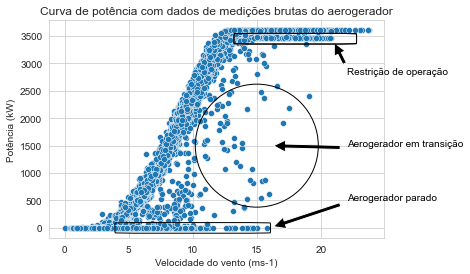

In [114]:
# potência em função da velocidade do vento após média horária
ax = sns.scatterplot(data=df_media_horaria, x='windspeed', y='power')
# add text annotation
plt.annotate("Restrição de operação", xy=(21, 3400), xycoords='data',
            xytext=(22, 2800), textcoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='left', size='medium', color='black', weight='normal')
t = plt.text(
    18, 3450, "                                            ", 
    ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="round4,pad=0.1", fill=False, ec="black", lw=1))

plt.annotate("Aerogerador parado", xy=(16, 0), xycoords='data',
            xytext=(22, 500), textcoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='left', size='medium', color='black', weight='normal')
t = plt.text(
    18, 3450, "                                            ", 
    ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="round4,pad=0.1", fill=False, ec="black", lw=1))

t = plt.text(
    10, 0, "                                                        ", 
    ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="round4,pad=0.1", fill=False, ec="black", lw=1))

plt.annotate("Aerogerador em transição", xy=(16, 1500), xycoords='data',
            xytext=(22, 1500), textcoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='left', size='medium', color='black', weight='normal')

t = plt.text(
    15, 1500, "                                            ", 
    ha="center", va="center", rotation=0, size=10,
    bbox=dict(boxstyle="circle,pad=0.1", fill=False, ec="black", lw=1))
ax.set_xlabel('Velocidade do vento (ms-1)')
ax.set_ylabel('Potência (kW)')
ax.set_title('Curva de potência com dados de medições brutas do aerogerador')

In [115]:
power_cut_in = 0.001 * 3600
wind_cut_in = 3.0
df_media_horaria.query('windspeed < @wind_cut_in')

,power,windspeed
datetime_hourly,,
2018-01-03 07:00:00,0.000,1.380
2018-01-03 08:00:00,0.000,1.750
2018-01-05 06:00:00,0.000,1.708
2018-01-05 07:00:00,0.000,1.880
2018-01-05 08:00:00,0.000,1.747
...,...,...
2018-12-31 07:00:00,0.000,0.903
2018-12-31 08:00:00,0.000,1.193
2018-12-31 09:00:00,0.000,0.953


In [116]:
# remover erros de medição de potência
df_media_horaria_erro_med = df_media_horaria.copy()
df_media_horaria_erro_med.loc[(df_media_horaria_erro_med['windspeed'] < wind_cut_in),'power'] = 0.0
df_media_horaria_erro_med.query('windspeed < @wind_cut_in')

,power,windspeed
datetime_hourly,,
2018-01-03 07:00:00,0.000,1.380
2018-01-03 08:00:00,0.000,1.750
2018-01-05 06:00:00,0.000,1.708
2018-01-05 07:00:00,0.000,1.880
2018-01-05 08:00:00,0.000,1.747
...,...,...
2018-12-31 07:00:00,0.000,0.903
2018-12-31 08:00:00,0.000,1.193
2018-12-31 09:00:00,0.000,0.953


In [117]:
df_media_horaria_erro_med.head(10)

,power,windspeed
datetime_hourly,,
2018-01-01 00:00:00,390.482,5.507
2018-01-01 01:00:00,460.538,5.642
2018-01-01 02:00:00,733.655,6.453
2018-01-01 03:00:00,909.362,6.813
2018-01-01 04:00:00,"1,393.520",7.750
2018-01-01 05:00:00,"1,149.600",7.237
2018-01-01 06:00:00,"1,100.075",7.183
2018-01-01 07:00:00,928.242,6.807
2018-01-01 08:00:00,614.652,5.987


In [118]:
# remover medições cujo aerogerador está parado ou com falha
df_media_horaria_erro_med.query('power <= @power_cut_in and windspeed >= @wind_cut_in')

,power,windspeed
datetime_hourly,,
2018-01-03 00:00:00,0.000,4.813
2018-01-03 01:00:00,0.000,6.050
2018-01-03 02:00:00,0.000,5.293
2018-01-03 03:00:00,0.000,3.827
2018-01-03 04:00:00,0.000,3.735
...,...,...
2018-12-30 04:00:00,0.000,3.655
2018-12-30 05:00:00,0.000,3.400
2018-12-30 17:00:00,0.588,3.265


In [119]:
df_media_horaria_erro_med.loc[(df_media_horaria_erro_med['power'] <= power_cut_in) & (df_media_horaria_erro_med['windspeed'] >= wind_cut_in),'power'] = np.nan
df_media_horaria_erro_med.query('power <= @power_cut_in and windspeed >= @wind_cut_in')

,power,windspeed
datetime_hourly,,


In [120]:
# remover medições onde o aerogerador excede o limite de Betz (16/27~0.59)
# 1. Calcular o coeficiente de potencia teórico
# 2. Remover pontos onde o limite seja maior do que 0.59
# A=10715m² e p(rho)=1.225
df_media_horaria_erro_med['cp'] = 2*df_media_horaria_erro_med['power'] / (1.225*df_media_horaria_erro_med['windspeed']*10715)
df_media_horaria_erro_med.cp.max()

0.04587753948749569

In [121]:
# remover medições onde o aerogerador encontra-se em transição de estado
# 1. criar bins de 0.5 m/s
# 2. efetuar boxplot para identificar outliers
dx = 0.5
bins = np.arange(0, 25, dx)
df_binned = df_media_horaria_erro_med.copy()
df_binned['bin'] = pd.cut(df_binned["windspeed"], bins)
df_binned

,power,windspeed,cp,bin
datetime_hourly,,,,
2018-01-01 00:00:00,390.482,5.507,0.011,"(5.5, 6.0]"
2018-01-01 01:00:00,460.538,5.642,0.012,"(5.5, 6.0]"
2018-01-01 02:00:00,733.655,6.453,0.017,"(6.0, 6.5]"
2018-01-01 03:00:00,909.362,6.813,0.020,"(6.5, 7.0]"
2018-01-01 04:00:00,"1,393.520",7.750,0.027,"(7.5, 8.0]"
...,...,...,...,...
2018-12-31 19:00:00,"1,065.438",6.483,0.025,"(6.0, 6.5]"
2018-12-31 20:00:00,"1,629.042",8.083,0.031,"(8.0, 8.5]"
2018-12-31 21:00:00,"2,135.533",9.122,0.036,"(9.0, 9.5]"


Text(0, 0.5, 'Potência de Saída (kW)')

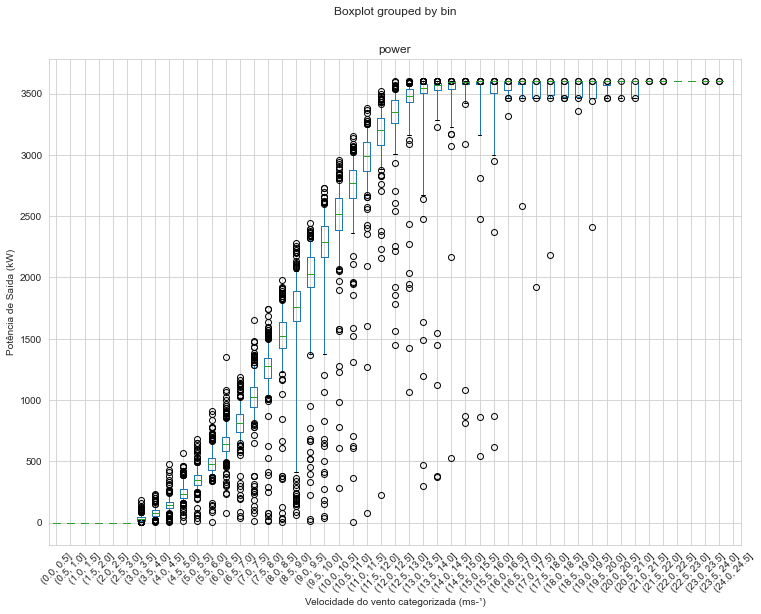

In [122]:
bp = df_binned.boxplot(column=['power'], by=['bin'], rot=45, figsize=(12,9), return_type='dict', whis=[5,95])
plt.xlabel('Velocidade do vento categorizada (ms-¹)')
plt.ylabel('Potência de Saída (kW)')

In [123]:
# print(bp['power'])
outliers = [flier.get_ydata() for flier in bp['power']["fliers"]]
boxes = [box.get_ydata() for box in bp['power']["boxes"]]
medians = [median.get_ydata() for median in bp['power']["medians"]]
whiskers = [whiskers.get_ydata() for whiskers in bp['power']["whiskers"]]
print(outliers[26])
print(medians[26])
print(whiskers[26])
print(boxes[26])

[467.28 1197.9733333333334 1492.835 2480.3966666666665 300.67333333333335
 1633.7783333333334 2636.983333333333 3603.485 3602.52 3601.525
 3601.9833333333336 3603.471666666667 3602.943333333333 3601.7566666666667]
[3547.89583333 3547.89583333]
[741.79458333 651.775     ]
[3501.15       3501.15       3573.70833333 3573.70833333 3501.15      ]


In [124]:
df_binned.groupby('bin').quantile([0.01,0.25,0.5,0.75,0.99]).to_clipboard()
df_described = df_binned[['power', 'bin']].groupby('bin').describe()

df_described['iqr'] = df_described['power']['75%'] - df_described['power']['25%']
df_described['inner_fence'] = 1.5 * df_described['iqr']
df_described['outer_fence'] = 3 * df_described['iqr']
df_described['lower_inner'] = df_described['power']['25%'] - df_described['inner_fence']
df_described['lower_outer'] = df_described['power']['25%'] - df_described['outer_fence']
df_described

power                                                  \
               count      mean     std       min       25%       50%   
bin                                                                    
(0.0, 0.5]     1.000     0.000     NaN     0.000     0.000     0.000   
(0.5, 1.0]    78.000     0.000   0.000     0.000     0.000     0.000   
(1.0, 1.5]   191.000     0.000   0.000     0.000     0.000     0.000   
(1.5, 2.0]   290.000     0.000   0.000     0.000     0.000     0.000   
(2.0, 2.5]   311.000     0.000   0.000     0.000     0.000     0.000   
(2.5, 3.0]   396.000     0.000   0.000     0.000     0.000     0.000   
(3.0, 3.5]   271.000    32.596  27.447     3.720    13.208    25.293   
(3.5, 4.0]   290.000    81.019  40.153     7.708    51.653    77.500   
(4.0, 4.5]   273.000   148.341  59.009     5.903   117.825   141.600   
(4.5, 5.0]   320.000   245.207  67.732    14.202   202.203   236.776   
(5.0, 5.5]   314.000   352.006  86.163    12.343   302.378   345.804   
(5.5, 6.0]   363.000   485.435 102.313     7.443   427.999   474.657   
(6.0, 6.5]   402.000   643.409 120.496    76.828   581.067   638.746   
(6.5, 7.0]   356.000   806.756 149.548    40.467   741.795   808.590   
(7.0, 7.5]   409.000 1,012.766 197.961     8.852   938.637 1,020.340   
(7.5, 8.0]   365.000 1,242.541 223.623    11.843 1,178.043 1,275.907   
(8.0, 8.5]   315.000 1,491.567 283.974     5.953 1,421.409 1,518.078   
(8.5, 9.0]   328.000 1,668.005 435.730    62.863 1,646.546 1,758.888   
(9.0, 9.5]   292.000 1,976.437 377.102    15.502 1,918.435 2,024.120   
(9.5, 10.0]  263.000 2,201.626 452.528    36.262 2,169.156 2,291.842   
(10.0, 10.5] 274.000 2,471.463 323.060   282.852 2,383.745 2,520.041   
(10.5, 11.0] 268.000 2,701.149 390.069     4.622 2,647.442 2,769.948   
(11.0, 11.5] 224.000 2,952.529 304.771    76.768 2,871.863 2,989.380   
(11.5, 12.0] 208.000 3,159.092 285.900   228.752 3,079.217 3,203.242   
(12.0, 12.5] 202.000 3,289.059 316.412 1,447.282 3,256.377 3,350.266   
(12.5, 13.0] 178.000 3,406.084 337.517 1,066.663 3,429.236 3,480.947   
(13.0, 13.5] 132.000 3,402.383 519.929   300.673 3,501.150 3,547.896   
(13.5, 14.0] 103.000 3,420.766 571.171   369.345 3,525.858 3,573.572   
(14.0, 14.5]  97.000 3,507.710 349.739   523.560 3,540.730 3,591.083   
(14.5, 15.0]  82.000 3,474.574 506.709   810.058 3,574.780 3,597.775   
(15.0, 15.5]  65.000 3,453.792 527.547   543.732 3,577.123 3,599.685   
(15.5, 16.0]  66.000 3,450.027 517.210   618.043 3,507.388 3,600.803   
(16.0, 16.5]  49.000 3,564.190  65.990 3,320.427 3,531.238 3,600.952   
(16.5, 17.0]  39.000 3,546.977 167.828 2,582.082 3,579.717 3,600.893   
(17.0, 17.5]  41.000 3,507.585 262.150 1,921.967 3,462.627 3,600.650   
(17.5, 18.0]  24.000 3,509.931 288.131 2,183.847 3,486.063 3,601.808   
(18.0, 18.5]  41.000 3,562.429  63.327 3,460.937 3,468.985 3,601.892   
(18.5, 19.0]  31.000 3,552.824  71.696 3,358.448 3,470.416 3,601.787   
(19.0, 19.5]  30.000 3,520.401 219.058 2,413.578 3,463.145 3,601.780   
(19.5, 20.0]  24.000 3,568.990  58.526 3,461.087 3,572.611 3,601.733   
(20.0, 20.5]  14.000 3,581.824  51.244 3,460.775 3,601.306 3,601.650   
(20.5, 21.0]  10.000 3,545.065  71.697 3,460.848 3,462.140 3,599.403   
(21.0, 21.5]   2.000 3,602.199   0.435 3,601.892 3,602.045 3,602.199   
(21.5, 22.0]   4.000 3,601.588   0.449 3,600.995 3,601.363 3,601.699   
(22.0, 22.5]   1.000 3,601.502     NaN 3,601.502 3,601.502 3,601.502   
(22.5, 23.0]   1.000 3,601.568     NaN 3,601.568 3,601.568 3,601.568   
(23.0, 23.5]   2.000 3,601.583   0.761 3,601.045 3,601.314 3,601.583   
(23.5, 24.0]   3.000 3,601.436   0.450 3,600.998 3,601.205 3,601.412   
(24.0, 24.5]   0.000       NaN     NaN       NaN       NaN       NaN   

                                     iqr inner_fence outer_fence lower_inner  \
                   75%       max                                               
bin                                                                            
(0.0, 0.5]       0.000     0.0

In [125]:
df_merged = df_binned.merge(df_described['lower_inner'], left_on='bin', right_index=True)
df_merged.head()

,power,windspeed,cp,bin,lower_inner
datetime_hourly,,,,,
2018-01-01 00:00:00,390.482,5.507,0.011,"(5.5, 6.0]",278.498
2018-01-01 01:00:00,460.538,5.642,0.012,"(5.5, 6.0]",278.498
2018-01-01 08:00:00,614.652,5.987,0.016,"(5.5, 6.0]",278.498
2018-01-01 09:00:00,671.510,5.985,0.017,"(5.5, 6.0]",278.498
2018-01-01 10:00:00,521.625,5.660,0.014,"(5.5, 6.0]",278.498


In [126]:
df_merged[['power', 'windspeed', 'bin', 'lower_inner']]

,power,windspeed,bin,lower_inner
datetime_hourly,,,,
2018-01-01 00:00:00,390.482,5.507,"(5.5, 6.0]",278.498
2018-01-01 01:00:00,460.538,5.642,"(5.5, 6.0]",278.498
2018-01-01 08:00:00,614.652,5.987,"(5.5, 6.0]",278.498
2018-01-01 09:00:00,671.510,5.985,"(5.5, 6.0]",278.498
2018-01-01 10:00:00,521.625,5.660,"(5.5, 6.0]",278.498
...,...,...,...,...
2018-03-02 22:00:00,"3,602.122",23.188,"(23.0, 23.5]","3,600.507"
2018-04-02 01:00:00,"3,601.045",23.055,"(23.0, 23.5]","3,600.507"
2018-04-02 05:00:00,"3,601.568",22.633,"(22.5, 23.0]","3,601.568"


In [127]:
df_merged.loc[df_merged['power'] < df_merged['lower_inner'], ['power']] = np.nan
df_merged.shape

(8437, 5)

Text(0, 0.5, 'Potência (kW)')

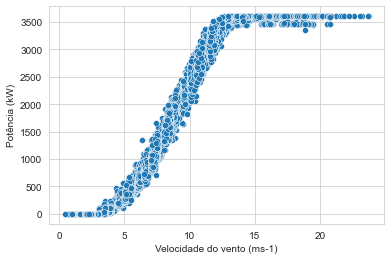

In [128]:
# potência em função da velocidade do vento após remoção de outliers
sns.scatterplot(data=df_merged, x='windspeed', y='power')
plt.xlabel('Velocidade do vento (ms-1)')
plt.ylabel('Potência (kW)')

<AxesSubplot:xlabel='windspeed', ylabel='power'>

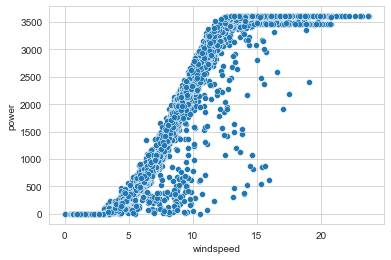

In [129]:
sns.scatterplot(data=df_media_horaria_erro_med, x='windspeed', y='power')

# Determinação da curva de potência
1. Determinação da curva de potência através do método descrito na IEC 61400 (sem turbulência)
2. Determinação da curva de potência através do uso de ML (regressão)
3. Determinação da curva de potência através do uso de ML (redes neurais artificiais)

In [130]:
df_merged.head()

,power,windspeed,cp,bin,lower_inner
datetime_hourly,,,,,
2018-01-01 00:00:00,390.482,5.507,0.011,"(5.5, 6.0]",278.498
2018-01-01 01:00:00,460.538,5.642,0.012,"(5.5, 6.0]",278.498
2018-01-01 08:00:00,614.652,5.987,0.016,"(5.5, 6.0]",278.498
2018-01-01 09:00:00,671.510,5.985,0.017,"(5.5, 6.0]",278.498
2018-01-01 10:00:00,521.625,5.660,0.014,"(5.5, 6.0]",278.498


Text(0, 0.5, 'Potência (kW)')

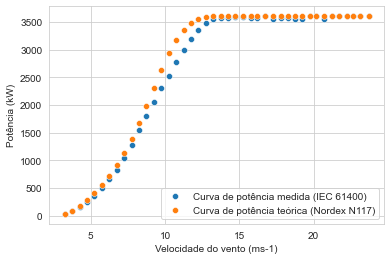

In [131]:
# 1.
# calc power curve
dx = 0.5
bins = np.arange(3.0, 26, dx)
left = df_merged.groupby(pd.cut(df_merged['windspeed'], bins)).mean()
right = df_original.groupby(pd.cut(df_original['Wind Speed (m/s)'], bins)).mean()
df_power_curve = left.merge(right=right, how='left', left_index=True, right_index=True)
sns.scatterplot(data=df_power_curve, x='windspeed', y='power', label='Curva de potência medida (IEC 61400)')
sns.scatterplot(data=df_power_curve, x='windspeed', y='Theoretical_Power_Curve (KWh)', label='Curva de potência teórica (Nordex N117)')
plt.xlabel('Velocidade do vento (ms-1)')
plt.ylabel('Potência (kW)')
# df_power_curve

In [132]:
df_media_horaria_erro_med.head()

,power,windspeed,cp
datetime_hourly,,,
2018-01-01 00:00:00,390.482,5.507,0.011
2018-01-01 01:00:00,460.538,5.642,0.012
2018-01-01 02:00:00,733.655,6.453,0.017
2018-01-01 03:00:00,909.362,6.813,0.020
2018-01-01 04:00:00,"1,393.520",7.750,0.027


In [50]:
# 2.
model_ols = smf.ols(formula='power ~ windspeed', data=df_merged)
res_ols = model_ols.fit()
res_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 2.011e+04
Date:                Fri, 14 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:11:57   Log-Likelihood:                -14002.
No. Observations:                1904   AIC:                         2.801e+04
Df Residuals:                    1902   BIC:                         2.802e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -800.6282     18.027    -44.412      0.000    -835.983    -765.273
windspeed    294.2310      2.075    141.825      0.000     290.162     298.300
==============================================================================
Omnibus:                       44.048   Durbin-Watson:                   0.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.072
Skew:                          -0.311   Prob(JB):                     4.93e-12
Kurtosis:                       3.520   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

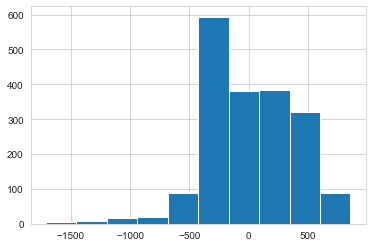

In [51]:
res_ols.resid.hist()

In [52]:
res_ols.resid.to_csv('res_ols.csv')
res_ols.resid

datetime_hourly
2018-10-01 00:00:00     -377.047
2018-10-01 22:00:00     -371.406
2018-10-02 02:00:00     -253.440
2018-10-02 12:00:00     -275.516
2018-10-02 13:00:00     -191.011
                         ...    
2018-12-24 16:00:00   -1,464.143
2018-12-24 17:00:00   -1,454.679
2018-12-24 18:00:00   -1,695.028
2018-12-24 19:00:00   -1,683.103
2018-12-24 20:00:00   -1,709.769
Length: 1904, dtype: float64

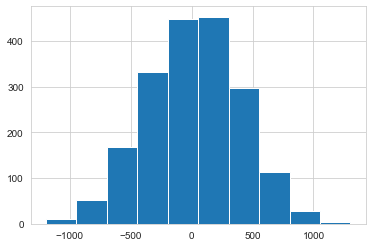

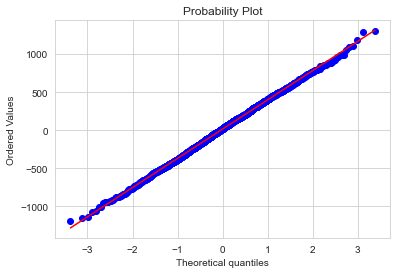

omnibus        0.350
Shapiro-Wilk   0.705
Lilliefors     0.470
KS             0.825
dtype: float64
Data are normally distributed


C:\Users\renat\AppData\Local\Temp\ipykernel_2116\3122075477.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pVals = pd.Series()


In [55]:
def check_normality(data):
    '''Check if the distribution is normal.'''
    # Generate and show a distribution
    numData = len(data)
    myMean = np.mean(data)
    mySD = np.std(data)
    
    # To get reproducable values, I provide a seed value
    np.random.seed(987654321)   
    
    data = stats.norm.rvs(myMean, mySD, size=numData)
    plt.hist(data)
    plt.show()

    # --- >>> START stats <<< ---
    # Graphical test: if the data lie on a line, they are pretty much
    # normally distributed
    _ = stats.probplot(data, plot=plt)
    plt.show()

    pVals = pd.Series()
    # The scipy normaltest is based on D-Agostino and Pearsons test that
    # combines skew and kurtosis to produce an omnibus test of normality.
    _, pVals['omnibus'] = stats.normaltest(data)

    # Shapiro-Wilk test
    _, pVals['Shapiro-Wilk'] = stats.shapiro(data)
    
    # Or you can check for normality with Lilliefors-test
    ksStats, pVals['Lilliefors'] = kstest_normal(data)
    
    # Alternatively with original Kolmogorov-Smirnov test
    _, pVals['KS'] = stats.kstest((data-np.mean(data))/np.std(data,ddof=1), 'norm')
    
    print(pVals)
    if pVals['omnibus'] > 0.05:
        print('Data are normally distributed')

check_normality(res_ols.resid)

                      power  windspeed    cp         bin  lower_inner  predict
datetime_hourly                                                               
2018-10-01 00:00:00 384.692      5.310 0.011  (5.0, 5.5]      144.176  761.738
2018-10-01 22:00:00 302.063      5.010 0.009  (5.0, 5.5]      144.176  673.469
2018-10-02 02:00:00 499.472      5.280 0.014  (5.0, 5.5]      144.176  752.912
2018-10-02 12:00:00 451.895      5.193 0.013  (5.0, 5.5]      144.176  727.411
2018-10-02 13:00:00 582.007      5.348 0.017  (5.0, 5.5]      144.176  773.017


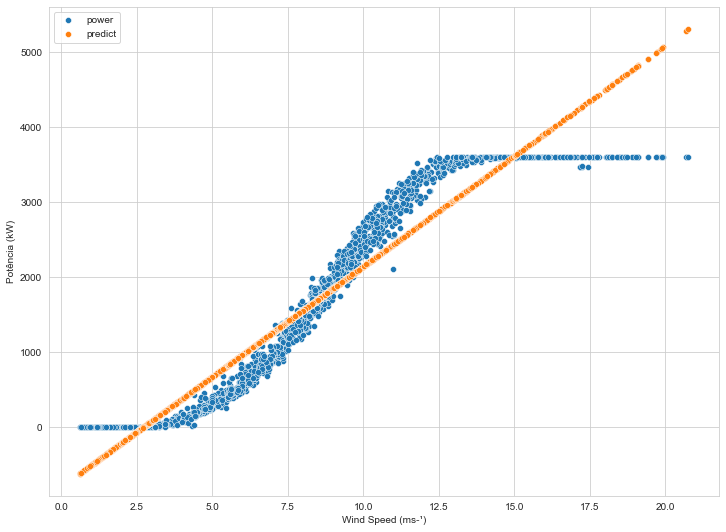

In [80]:
def my_plot_predict(df, model, x='windspeed', y='power', lmbda=None):
    df_merged_predict = df.copy()
    df_merged_predict['predict'] = model.predict(df_merged_predict)
    if lmbda is not None:
        from scipy.special import inv_boxcox
        df_merged_predict['predict2'] = inv_boxcox(df_merged_predict['predict'], lmbda)

    fig, ax = plt.subplots(figsize=(12,9))
    sns.scatterplot(data=df_merged_predict, x=x, y=y, label='power')
    sns.scatterplot(data=df_merged_predict, x=x, y='predict', label='predict')
    plt.xlabel('Wind Speed (ms-¹)')
    plt.ylabel('Potência (kW)')
    print(df_merged_predict.head())
my_plot_predict(df_merged, res_ols)

In [133]:
pandas2ri.activate()

shapiro_francia = importr('nortest')

#valor = shapiro_francia.sf_test(res_ols.resid) # Passe para o teste shapiro francia os resíduos do modelo.
# p_value >= 0.05 tem aderência à normalidade
#print(f'O valor da abscisa correspondente é: {valor[0]}')
#print(f'O valor do p-value é: {valor[1]}')
#print(f'O nome do método é: {valor[2]}')
#print(f'O valor dos resíduos são: {valor[0]}')


#The Shapiro-Wilks test for normality is one of three general normality tests designed to detect all departures 
#from normality.  It is comparable in power to the other two tests.
#The test rejects the hypothesis of normality when the p-value is less than or equal to 0.05.  
#Failing the normality test allows you to state with 95% confidence the data does not fit the normal distribution.
#Passing the normality test only allows you to state no significant departure from normality was found.

In [68]:
# box cox transformation
train = df_merged.query('power > 0').copy()
y_hat, lmbda = stats.boxcox(train['power'].values)
train['power_hat'] = y_hat
train.head()

,power,windspeed,cp,bin,lower_inner,power_hat
datetime_hourly,,,,,,
2018-10-01 00:00:00,384.692,5.310,0.011,"(5.0, 5.5]",144.176,42.754
2018-10-01 22:00:00,302.063,5.010,0.009,"(5.0, 5.5]",144.176,37.365
2018-10-02 02:00:00,499.472,5.280,0.014,"(5.0, 5.5]",144.176,49.407
2018-10-02 12:00:00,451.895,5.193,0.013,"(5.0, 5.5]",144.176,46.747
2018-10-02 13:00:00,582.007,5.348,0.017,"(5.0, 5.5]",144.176,53.755


In [57]:
model_ols_bc = smf.ols(formula='power_hat ~ windspeed', data=train)
res_ols_bc = model_ols_bc.fit()
res_ols_bc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              power_hat   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     9565.
Date:                Fri, 14 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:18:32   Log-Likelihood:                -6490.3
No. Observations:                1562   AIC:                         1.298e+04
Df Residuals:                    1560   BIC:                         1.300e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.1469      1.043     -3.978      0.000      -6.192      -2.102
windspeed     10.6844      0.109     97.800      0.000      10.470      10.899
==============================================================================
Omnibus:                      313.040   Durbin-Watson:                   0.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              624.397
Skew:                          -1.173   Prob(JB):                    2.59e-136
Kurtosis:                       5.022   Cond. No.                         25.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

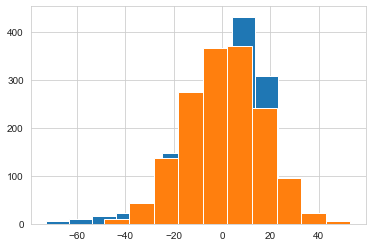

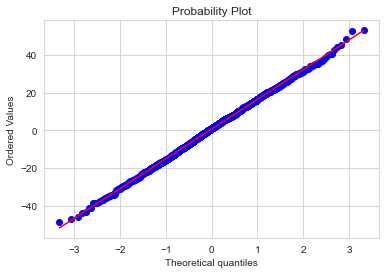

omnibus        0.597
Shapiro-Wilk   0.838
Lilliefors     0.444
KS             0.797
dtype: float64
Data are normally distributed


C:\Users\renat\AppData\Local\Temp\ipykernel_2116\3122075477.py:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pVals = pd.Series()


In [58]:
res_ols_bc.resid.hist()
res_ols_bc.resid.to_csv('res_ols_bc.csv')
res_ols_bc.resid
check_normality(res_ols_bc.resid)

                      power  windspeed    cp         bin  lower_inner  \
datetime_hourly                                                         
2018-10-01 00:00:00 384.692      5.310 0.011  (5.0, 5.5]      144.176   
2018-10-01 22:00:00 302.063      5.010 0.009  (5.0, 5.5]      144.176   
2018-10-02 02:00:00 499.472      5.280 0.014  (5.0, 5.5]      144.176   
2018-10-02 12:00:00 451.895      5.193 0.013  (5.0, 5.5]      144.176   
2018-10-02 13:00:00 582.007      5.348 0.017  (5.0, 5.5]      144.176   

                     power_hat  predict  predict2  
datetime_hourly                                    
2018-10-01 00:00:00     42.754   52.587   559.256  
2018-10-01 22:00:00     37.365   49.382   499.014  
2018-10-02 02:00:00     49.407   52.267   553.087  
2018-10-02 12:00:00     46.747   51.341   535.447  
2018-10-02 13:00:00     53.755   52.997   567.184  


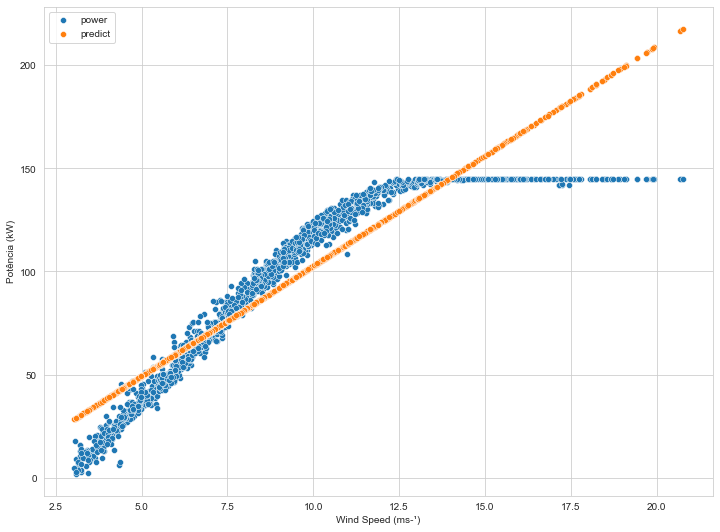

In [82]:
my_plot_predict(train, res_ols_bc, y='power_hat', lmbda=lmbda)

In [134]:
#valor_bc = shapiro_francia.sf_test(res_ols_bc.resid) # Passe para o teste shapiro francia os resíduos do modelo.
# p_value >= 0.05 tem aderência à normalidade
#print(f'O valor da abscisa correspondente é: {valor_bc[0]}')
#print(f'O valor do p-value é: {valor_bc[1]}')
#print(f'O nome do método é: {valor_bc[2]}')
#print(f'O valor dos resíduos são: {valor_bc[0]}')

In [135]:
# criando dummies com a velocidade do vento
df_merged.head()

,power,windspeed,cp,bin,lower_inner
datetime_hourly,,,,,
2018-01-01 00:00:00,390.482,5.507,0.011,"(5.5, 6.0]",278.498
2018-01-01 01:00:00,460.538,5.642,0.012,"(5.5, 6.0]",278.498
2018-01-01 08:00:00,614.652,5.987,0.016,"(5.5, 6.0]",278.498
2018-01-01 09:00:00,671.510,5.985,0.017,"(5.5, 6.0]",278.498
2018-01-01 10:00:00,521.625,5.660,0.014,"(5.5, 6.0]",278.498


In [158]:
df_merged_dummies = pd.get_dummies(df_merged, columns=['bin'])
df_merged_dummies.head(1)

,power,windspeed,lower_inner,"bin_(0.0, 0.5]","bin_(0.5, 1.0]","bin_(1.0, 1.5]","bin_(1.5, 2.0]","bin_(2.0, 2.5]","bin_(2.5, 3.0]","bin_(3.0, 3.5]",...,"bin_(19.5, 20.0]","bin_(20.0, 20.5]","bin_(20.5, 21.0]","bin_(21.0, 21.5]","bin_(21.5, 22.0]","bin_(22.0, 22.5]","bin_(22.5, 23.0]","bin_(23.0, 23.5]","bin_(23.5, 24.0]","bin_(24.0, 24.5]"
datetime_hourly,,,,,,,,,,,,,,,,,,,,,
2018-01-01,390.482,5.507,278.498,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [192]:
df_merged_dummies.columns = [c.replace('(', '').replace(']', '').replace(' ','').replace('.','').replace(',','_') for c in df_merged_dummies.columns]
df_merged_dummies.head(1)

,power,windspeed,lower_inner,bin_00_05,bin_05_10,bin_10_15,bin_15_20,bin_20_25,bin_25_30,bin_30_35,...,bin_195_200,bin_200_205,bin_205_210,bin_210_215,bin_215_220,bin_220_225,bin_225_230,bin_230_235,bin_235_240,bin_240_245
datetime_hourly,,,,,,,,,,,,,,,,,,,,,
2018-01-01,390.482,5.507,278.498,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
all_columns = [item for item in df_merged_dummies.columns if item not in ['power', 'windspeed', 'lower_inner']]
my_formula = "power ~ " + "+".join(all_columns)
model_ols_dummy = smf.ols(formula=my_formula, data=df_merged_dummies)
res_ols_dummy = model_ols_dummy.fit()
res_ols_dummy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 2.333e+04
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:17:36   Log-Likelihood:                -47216.
No. Observations:                7743   AIC:                         9.453e+04
Df Residuals:                    7695   BIC:                         9.486e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2243.5437      5.034    445.649      0.000    2233.675    2253.412
bin_00_05   -2243.5437    105.883    -21.189      0.000   -2451.103   -2035.985
bin_05_10   -2243.5437     12.990   -172.707      0.000   -2269.009   -2218.079
bin_10_15   -2243.5437      9.160   -244.923      0.000   -2261.500   -2225.587
bin_15_20   -2243.5437      7.995   -280.627      0.000   -2259.216   -2227.872
bin_20_25   -2243.5437      7.830   -286.525      0.000   -2258.893   -2228.194
bin_25_30   -2243.5437      7.321   -306.469      0.000   -2257.894   -2229.193
bin_30_35   -2210.9479      8.162   -270.878      0.000   -2226.948   -2194.948
bin_35_40   -2162.5250      7.995   -270.493      0.000   -2178.197   -2146.853
bin_40_45   -2092.3153      8.200   -255.162      0.000   -2108.389   -2076.241
bin_45_50   -1995.8871      7.794   -256.088      0.000   -2011.165   -1980.609
bin_50_55   -1885.8716      7.853   -240.161      0.000   -1901.265   -1870.479
bin_55_60   -1751.7309      7.528   -232.682      0.000   -1766.489   -1736.973
bin_60_65   -1591.3452      7.340   -216.796      0.000   -1605.734   -1576.956
bin_65_70   -1419.4779      7.594   -186.913      0.000   -1434.365   -1404.591
bin_70_75   -1202.1574      7.330   -163.996      0.000   -1216.527   -1187.788
bin_75_80    -968.9485      7.552   -128.304      0.000    -983.752    -954.145
bin_80_85    -704.0531      7.898    -89.139      0.000    -719.536    -688.570
bin_85_90    -452.0662      7.922    -57.066      0.000    -467.595    -436.537
bin_90_95    -187.0720      8.116    -23.049      0.000    -202.982    -171.162
bin_95_100     62.5726      8.415      7.436      0.000      46.077      79.069
bin_100_105   278.9888      8.239     33.863      0.000     262.839     295.139
bin_105_110   532.7416      8.330     63.957      0.000     516.413     549.070
bin_110_115   747.9015      8.769     85.291      0.000     730.712     765.091
bin_115_120   949.7582      8.984    105.712      0.000     932.146     967.370
bin_120_125  1110.1947      9.160    121.198      0.000    1092.238    1128.151
bin_125_130  1243.2689      9.760    127.385      0.000    1224.137    1262.401
bin_130_135  1301.8762     11.073    117.572      0.000    1280.170    1323.582
bin_135_140  1321.1430     12.289    107.503      0.000    1297.053    1345.233
bin_140_145  1328.9385     12.232    108.641      0.000    1304.960    1352.917
bin_145_150  1349.6580     13.692     98.576      0.000    1322.819    1376.497
bin_150_155  1353.3504     15.375     88.021      0.000    1323.211    1383.490
bin_155_160  1328.4380     14.447     91.952      0.000    1300.118    1356.758
bin_160_165  1325.7248     16.074     82.475      0.000    1294.215    1357.235
bin_165_170  1356.8270     19.955     67.994      0.000    1317.710    1395.944
bin_170_175  1303.6813     17.464     74.65

datetime_hourly
2018-01-01 00:00:00   -101.331
2018-01-01 01:00:00    -31.274
2018-01-01 08:00:00    122.839
2018-01-01 09:00:00    179.697
2018-01-01 10:00:00     29.812
                        ...   
2018-03-02 22:00:00      0.538
2018-04-02 01:00:00     -0.538
2018-04-02 05:00:00     -0.000
2018-04-02 06:00:00     -0.000
2018-05-04 21:00:00      0.000
Length: 7743, dtype: float64

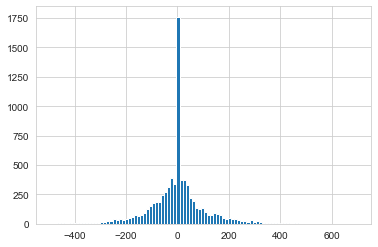

In [197]:
res_ols_dummy.resid.hist(bins=100)
res_ols_dummy.resid.to_csv('res_ols_dummy.csv')
res_ols_dummy.resid

<AxesSubplot:xlabel='windspeed', ylabel='power'>

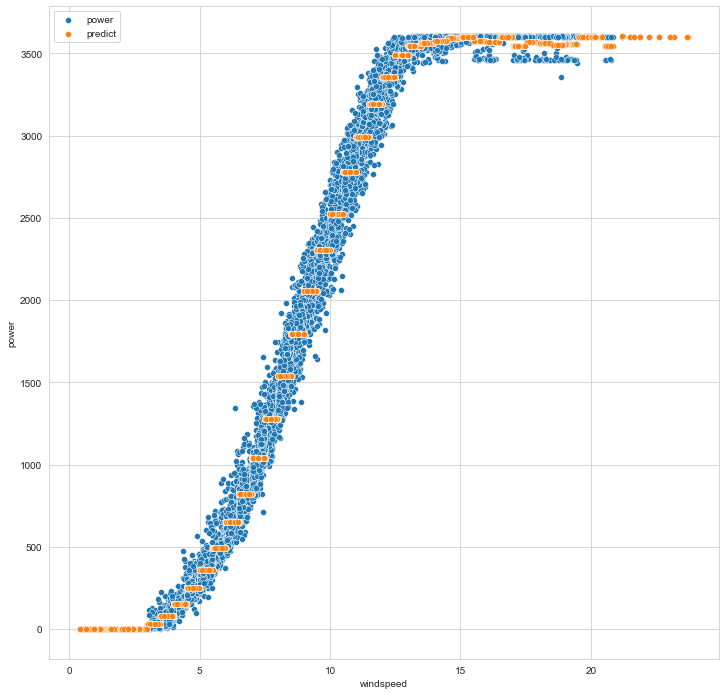

In [230]:
#df_test['predict'] = 
df_merged_dummies_predict = df_merged_dummies.copy()
df_merged_dummies_predict['predict'] = res_ols_dummy.predict(df_merged_dummies_predict)

fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(data=df_merged_dummies_predict, x='windspeed', y='power', label='power')
sns.scatterplot(data=df_merged_dummies_predict, x='windspeed', y='predict', label='predict')

<AxesSubplot:xlabel='windspeed', ylabel='power'>

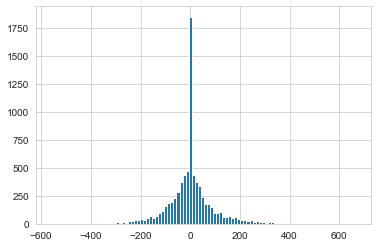

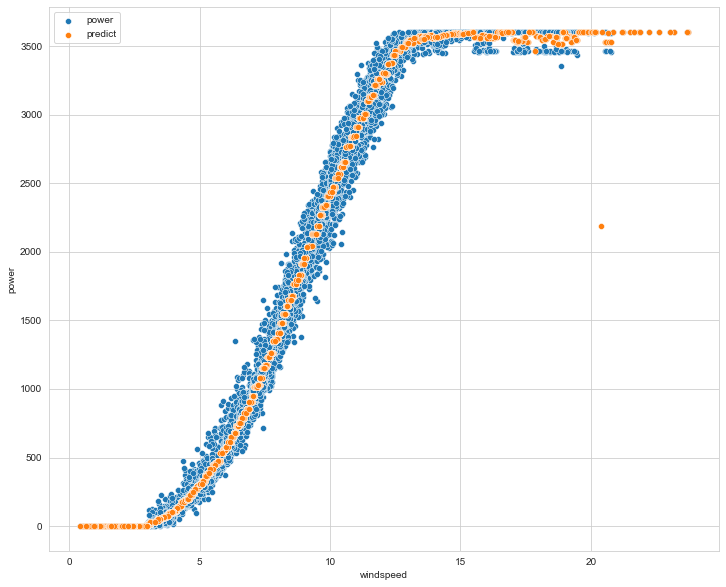

In [235]:
# nova tentativa com bins menores
dx = 0.1
bins = np.arange(0, 25, dx)
df_binned_01 = df_merged.copy()
df_binned_01['bin'] = pd.cut(df_binned_01["windspeed"], bins)
df_binned_01

df_merged_dummies_01 = pd.get_dummies(df_binned_01, columns=['bin'])
df_merged_dummies_01.columns = [c.replace('(', '').replace(']', '').replace(' ','').replace('.','').replace(',','_') for c in df_merged_dummies_01.columns]

all_columns_01 = [item for item in df_merged_dummies_01.columns if item not in ['power', 'windspeed', 'lower_inner']]
my_formula_01 = "power ~ " + "+".join(all_columns_01)
model_ols_dummy_01 = smf.ols(formula=my_formula_01, data=df_merged_dummies_01)
res_ols_dummy_01 = model_ols_dummy_01.fit()
res_ols_dummy_01.summary()

res_ols_dummy_01.resid.hist(bins=100)

df_merged_dummies_predict_01 = df_merged_dummies_01.copy()
df_merged_dummies_predict_01['predict'] = res_ols_dummy_01.predict(df_merged_dummies_predict_01)

fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(data=df_merged_dummies_predict_01, x='windspeed', y='power', label='power')
sns.scatterplot(data=df_merged_dummies_predict_01, x='windspeed', y='predict', label='predict')

In [265]:
df_merged_dummies_01.columns
array_predict = np.zeros(252)
#array_predict[int(10/0.1)] = 1
array_predict[1] = 1
df_serialize = pd.DataFrame([array_predict], columns=df_merged_dummies_01.columns)
df_serialize

res_ols_dummy_01.predict(df_serialize)
#https://mlatcl.github.io/deepnn/background/background-basis-functions.html

0   2,188.865
dtype: float64

In [136]:
# criando modelo usando redes neurais

#MLPRegressor(hidden_layer_sizes=(100,), 
#                               activation='relu', *, solver='adam', alpha=0.0001, 
#                               batch_size='auto', learning_rate='constant', 
#                               learning_rate_init=0.001, power_t=0.5, max_iter=200, 
#                               shuffle=True, random_state=None, tol=0.0001, verbose=False, 
#                               warm_start=False, momentum=0.9, nesterovs_momentum=True, 
#                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, 
#                               beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

df_merged_dropna = df_merged.dropna()

#sc = StandardScaler()
#df_merged_standardized = pd.DataFrame()
#df_merged_standardized[['power', 'windspeed']] = sc.fit_transform(df_merged_dropna[['power', 'windspeed']])
df_merged_standardized = df_merged_dropna.copy()

X = df_merged_standardized['windspeed'].values.reshape((len(df_merged_standardized['windspeed'].values),1))
y = df_merged_standardized['power']
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)
regr = MLPRegressor(random_state=1, max_iter=1000, activation='tanh', hidden_layer_sizes=(150,)).fit(X_train, y_train)
regr.predict(X_test[:2])

regr.score(X_test, y_test)


(7743, 1)
(7743,)


D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9942960963726113

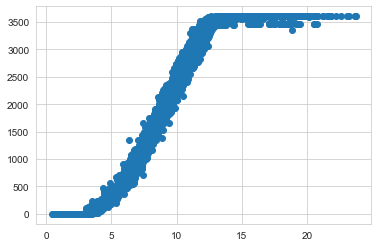

In [137]:
plt.scatter(X_train, y_train)

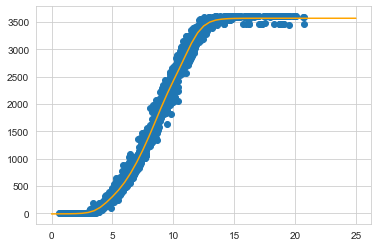

In [138]:
plt.scatter(X_test, y_test)
plt.plot(np.linspace(0,25,51), regr.predict(np.linspace(0,25,51).reshape((51,1))), color='orange')

# Séries temporais

,windspeed
count,50530.000000
mean,7.557947
std,4.227181
min,0.000000
25%,4.200000
50%,7.100000
75%,10.300000
max,25.210000


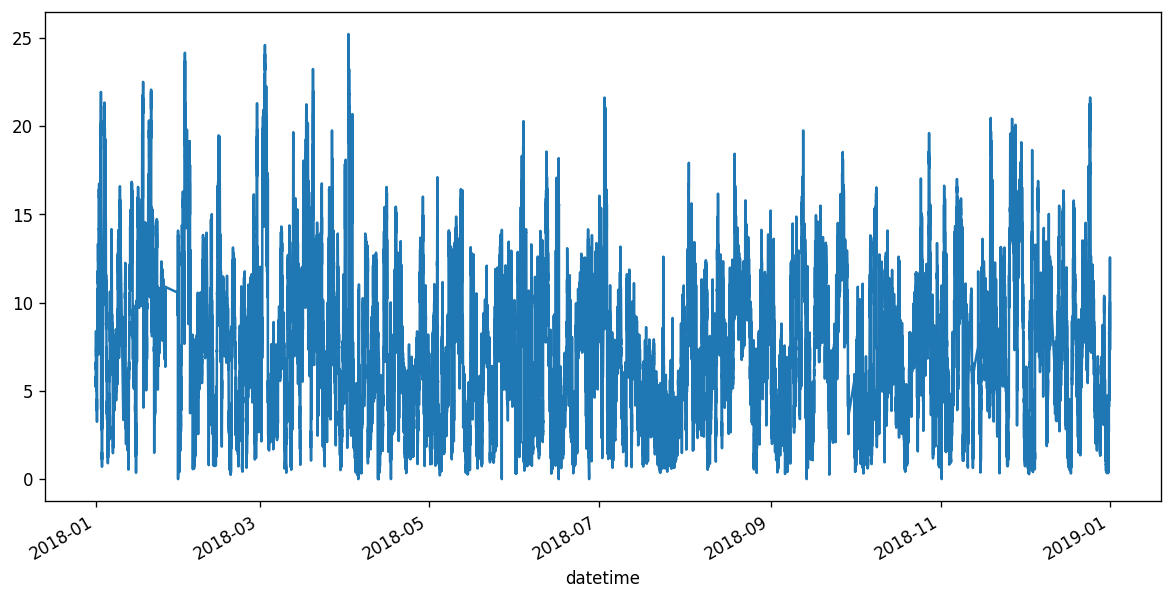

In [448]:
# predizer a velocidade do vento para 24h adiante
df_serie_temporal = df[['windspeed']].copy()
#df_serie_temporal.to_csv('serie_temporal.csv')
fig_st, axst = plt.subplots(figsize=(12,6))
df_serie_temporal['windspeed'].plot()
df_serie_temporal.describe()

<AxesSubplot:xlabel='datetime'>

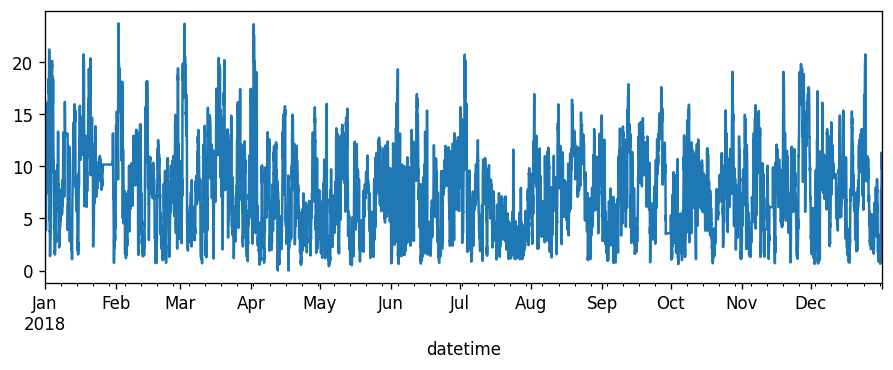

In [449]:
df_serie_temporal = df_serie_temporal.resample('H').mean().ffill()
df_serie_temporal.to_csv('serie_temporal.csv')
df_serie_temporal.head()
df_serie_temporal['windspeed'].plot()

In [450]:
df_serie_temporal['windspeed'].isna().sum()

0

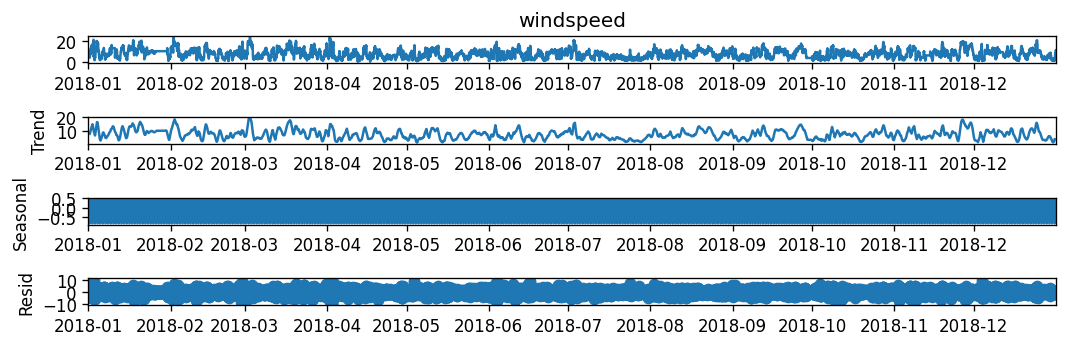

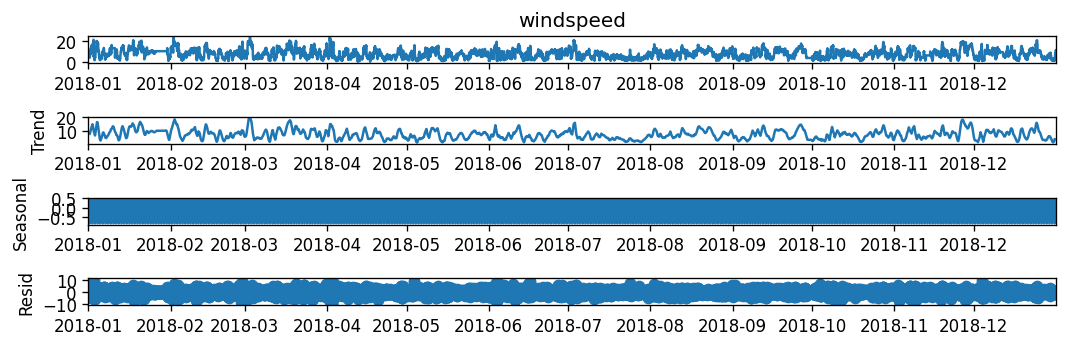

In [452]:
result = seasonal_decompose(x=df_serie_temporal['windspeed'].dropna(), model='additive')
result.plot()

In [334]:
from pmdarima.arima.utils import ndiffs, nsdiffs
import pmdarima as pm

adf_test = pm.arima.ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(df_serie_temporal.diff(1).dropna())
print(p_val)
print(should_diff)
kpss_test = pm.arima.KPSSTest(alpha=0.05)
p_val, should_diff = kpss_test.should_diff(df_serie_temporal.diff(1).dropna())
print(p_val)
print(should_diff)
pp_test = pm.arima.PPTest(alpha=0.05)
p_val, should_diff = pp_test.should_diff(df_serie_temporal.diff(1).dropna())
print(p_val)
print(should_diff)

# Estimate the number of differences using an ADF test:
n_adf = ndiffs(df_serie_temporal.diff(1).dropna(), test='adf')  # -> 0
print(n_adf)
# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(df_serie_temporal.diff(1).dropna(), test='kpss')  # -> 0
print(n_kpss)
# Or a PP test:
n_pp = ndiffs(df_serie_temporal.diff(1).dropna(), test='pp')  # -> 0
print(n_pp)


ns_kpss = nsdiffs(df_serie_temporal, m=2)  # -> 0
print(f'ns_diffs {ns_kpss}')

assert n_adf == n_kpss == n_pp == 0

0.01
False
0.1
False
0.01
False
0
0
0
ns_diffs 0


In [335]:
# biblioteca adfuller
from statsmodels.tsa.stattools import adfuller

#result = adfuller(df_serie_temporal['windspeed'], autolag='AIC')
result = adfuller(df_serie_temporal['windspeed'].diff(1).dropna(), autolag='AIC')

print('Test statistic: ' , result[0])
print('p-value: '  ,result[1])
print('Critical Values:' ,result[4])

# como p_value < 0.05, a série temporal é estacionária

sm.stats.acorr_ljungbox(df_serie_temporal['windspeed'].diff(1).dropna(), lags=None)

Test statistic:  -12.708701378897896
p-value:  1.0414470348178088e-23
Critical Values: {'1%': -3.4333490866177807, '5%': -2.862864895984805, '10%': -2.5674753077239294}


,lb_stat,lb_pvalue
1,6.049461,0.013911
2,9.197251,0.010066
3,9.874216,0.019666
4,9.895863,0.042219
5,13.059659,0.022826
6,24.093248,0.000502
7,25.288857,0.000674
8,25.290935,0.001388
9,32.562071,0.000159
10,35.258219,0.000113


{'period1': 23.9972602739726, 'freq1': 0.041671423678502115, 'power1': 102.17766883189485, 'period2': 11.9986301369863, 'freq2': 0.08334284735700423, 'power2': 92.72020701743118, 'period3': 10.033218785796105, 'freq3': 0.099668911976253, 'power3': 41.009451414808126, 'period4': 13.45468509984639, 'freq4': 0.07432355291699966, 'power4': 37.121388284769075, 'period5': 2.866164921465969, 'freq5': 0.34889827605891083, 'power5': 34.26898216462899, 'period6': 5.695058517555267, 'freq6': 0.17559082086996233, 'power6': 33.97749413743902, 'period7': 9.469189189189189, 'freq7': 0.10560566274688891, 'power7': 33.516094134678745}


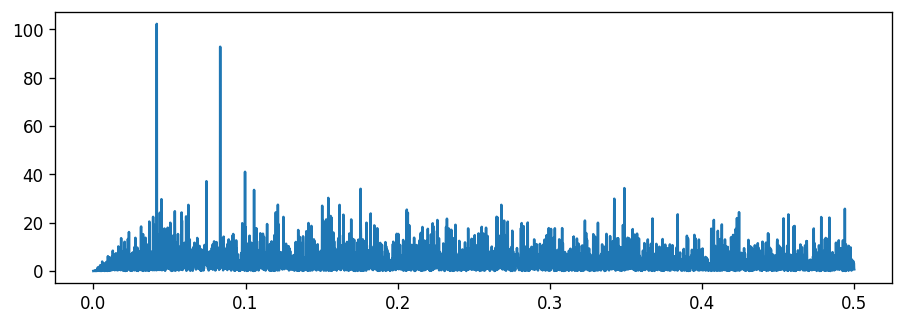

In [405]:
# seasonality with sarima model
from scipy import signal
def my_periodogram(v):
    f, Pxx = signal.periodogram(v.dropna())
    plt.plot(f, Pxx)
    top_3_periods = {}

    # get indices for 3 highest Pxx values
    top3_freq_indices = np.flip(np.argsort(Pxx), 0)[0:7]

    # use indices from previous step to
    # get 3 frequencies with highest power
    freqs = f[top3_freq_indices]

    # use same indices to get powers as well
    power = Pxx[top3_freq_indices]

    # we are interested in period and it is calculated as 1/frequency 
    periods = 1 / np.array(freqs)

    # populate dict with calculated values
    top_3_periods['period1'] = periods[0]
    top_3_periods['freq1'] = freqs[0]
    top_3_periods['power1'] = power[0]

    top_3_periods['period2'] = periods[1]
    top_3_periods['freq2'] = freqs[1]
    top_3_periods['power2'] = power[1]

    top_3_periods['period3'] = periods[2]
    top_3_periods['freq3'] = freqs[2]
    top_3_periods['power3'] = power[2]

    top_3_periods['period4'] = periods[3]
    top_3_periods['freq4'] = freqs[3]
    top_3_periods['power4'] = power[3]

    top_3_periods['period5'] = periods[4]
    top_3_periods['freq5'] = freqs[4]
    top_3_periods['power5'] = power[4]

    top_3_periods['period6'] = periods[5]
    top_3_periods['freq6'] = freqs[5]
    top_3_periods['power6'] = power[5]

    top_3_periods['period7'] = periods[6]
    top_3_periods['freq7'] = freqs[6]
    top_3_periods['power7'] = power[6]

    print(top_3_periods)

my_periodogram(df_serie_temporal['windspeed'].diff(1))

In [337]:
df_serie_temporal.diff(1).dropna().describe()

,windspeed
count,2207.000000
mean,0.002059
std,1.368377
min,-15.080000
25%,-0.580833
50%,0.000000
75%,0.601667
max,10.133333


In [338]:
df_serie_temporal.diff(1).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2018-10-01 00:00:00 to 2018-12-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   windspeed  2207 non-null   float64
dtypes: float64(1)
memory usage: 34.5 KB


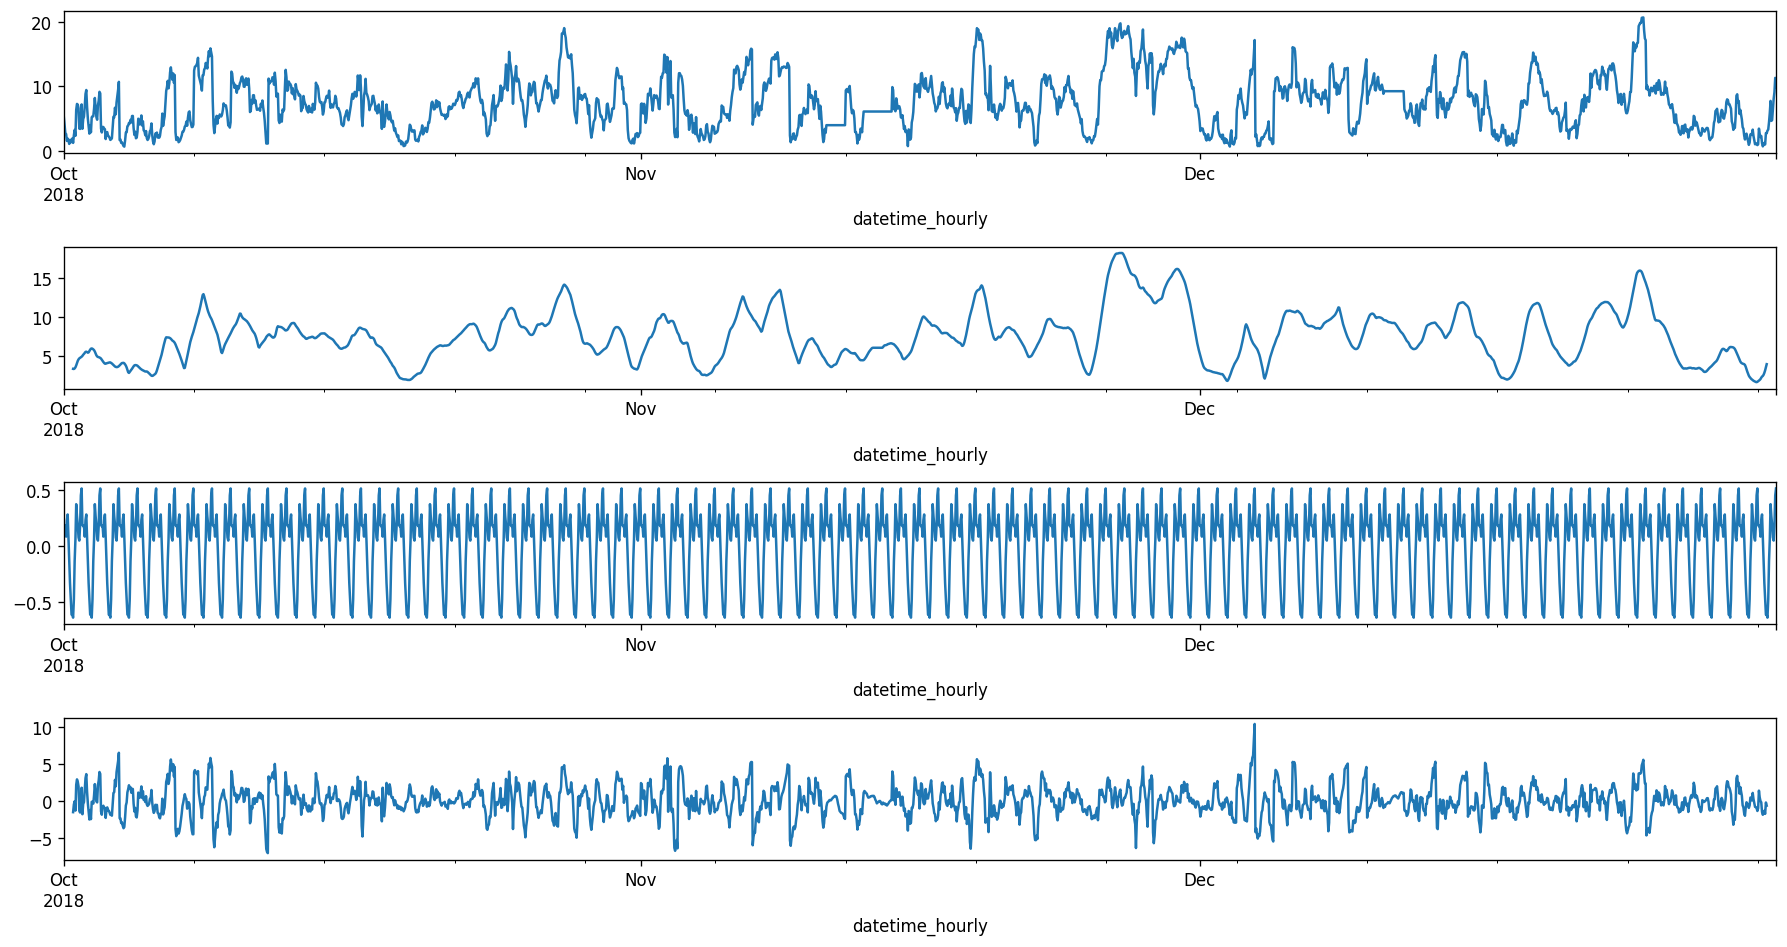

In [394]:
#Salvar a decoposição em result
from statsmodels.tsa.seasonal import seasonal_decompose
#result = seasonal_decompose(x=df_serie_temporal['windspeed'].asfreq('D').fillna(0).diff(7).dropna(), model='additive')
result = seasonal_decompose(x=df_serie_temporal['windspeed'].dropna(), model='additive')

#Plotar em tamanho maior
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,8))
#result.plot()
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)
plt.tight_layout()

{'period1': 7.996376811594202, 'freq1': 0.12505663797009517, 'power1': 13.537976582231838, 'period2': 23.989130434782606, 'freq2': 0.04168554599003172, 'power2': 11.477083650191782, 'period3': 5.997282608695651, 'freq3': 0.16674218396012688, 'power3': 11.15133563921423, 'period4': 11.994565217391303, 'freq4': 0.08337109198006344, 'power4': 11.066063191795156, 'period5': 2.9986413043478257, 'freq5': 0.33348436792025377, 'power5': 3.846034394395181, 'period6': 3.4270186335403725, 'freq6': 0.29179882193022205, 'power6': 2.670294322938027, 'period7': 2.398913043478261, 'freq7': 0.4168554599003172, 'power7': 1.9767575957826287}


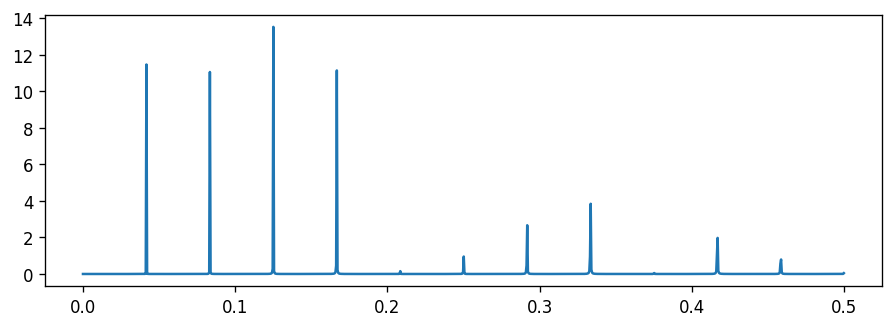

In [340]:
my_periodogram(result.seasonal)

# SARIMA

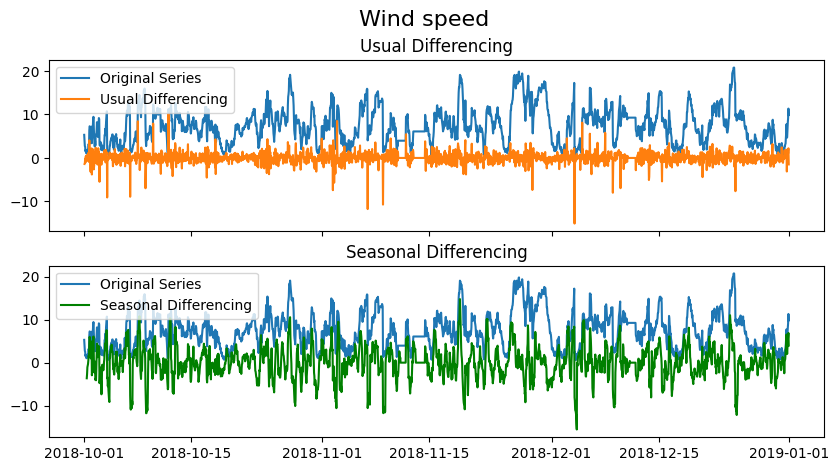

In [344]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df_serie_temporal[:], label='Original Series')
axes[0].plot(df_serie_temporal[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Defferencing
axes[1].plot(df_serie_temporal[:], label='Original Series')
axes[1].plot(df_serie_temporal[:].diff(8), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Wind speed', fontsize=16)
plt.show()

ADF Statistic: -6.346605
p-value: 0.000000


D:\OneDrive\Trabalho\Ambientes Python\Python310\eawar\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


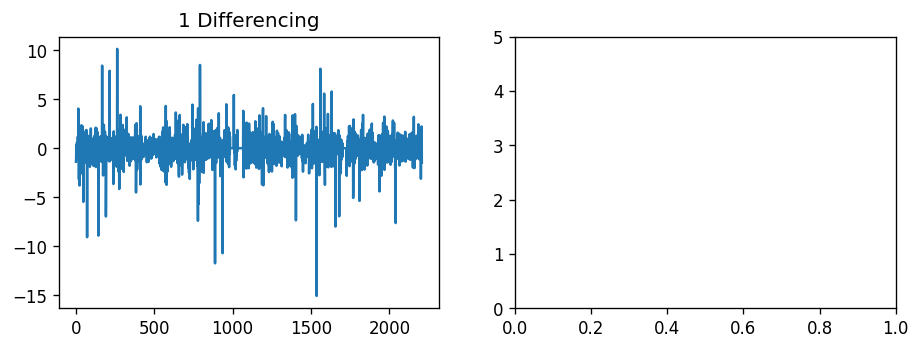

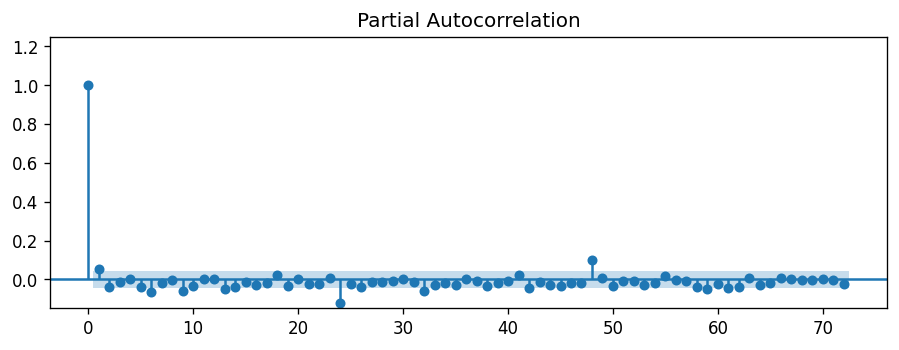

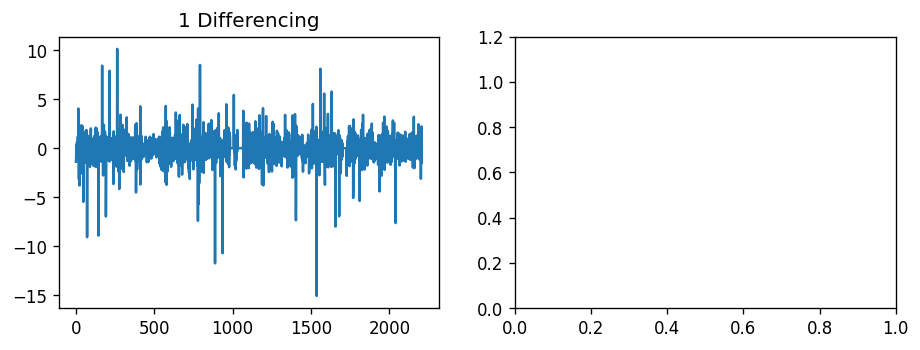

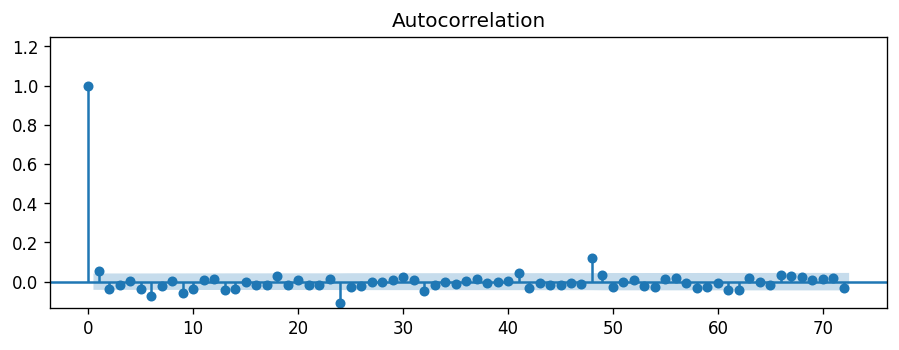

In [396]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from numpy import log
result = adfuller(df_serie_temporal.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# if p-value <= 0.05 Reject the null hypothesis (H0), 
# the data does not have a unit root and is stationary.
periods = 1
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df_serie_temporal.diff(periods=periods).values)
axes[0].set_title(str(periods)+' Differencing')
axes[1].set(ylim=(0,5))
#plot_pacf(df_serie_temporal.diff(periods=periods).dropna().values, ax=axes[1], lags=20, auto_ylims=True)
plot_pacf(df_serie_temporal.diff(periods=periods).dropna().values, lags=72, auto_ylims=True, alpha=.05)
#plot_pacf(df_serie_temporal.dropna().values, ax=axes[1], lags=20, auto_ylims=True, alpha=.05)
# existe uma correlação significativa no lag 1 seguido por correlações que não são significativas. 
# Este padrão indica um termo auto-regressivo de ordem 1.
plt.show()

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df_serie_temporal.diff(periods=periods).values)
axes[0].set_title(str(periods)+' Differencing')
axes[1].set(ylim=(0,1.2))
#plot_acf(df_serie_temporal.diff(periods=periods).dropna().values, ax=axes[1], lags=20, auto_ylims=True)
plot_acf(df_serie_temporal.diff(periods=periods).dropna().values, lags=72, auto_ylims=True, alpha=.05)

#plot_acf(df_serie_temporal['windspeed'].dropna().values, lags=80, auto_ylims=True, alpha=.05)
#
# Correlações significativas no primeiro ou segundo lag, 
#seguidas por correlações que não são significativas.

# Um termo de média móvel nos dados. O número de correlações significativas 
# indica a ordem do termo da média móvel.
plt.show()

,acf,ci_lim_inf,ci_lim_sup,significative
0,1.000000,1.000000,1.000000,True
1,0.052319,0.010599,0.094040,True
2,-0.037732,-0.079566,0.004102,False
3,-0.017494,-0.059388,0.024399,False
4,0.003128,-0.038779,0.045034,False
5,-0.037802,-0.079709,0.004105,False
6,-0.070578,-0.112544,-0.028612,True
7,-0.023228,-0.065400,0.018944,False
8,0.000968,-0.041226,0.043162,False
9,-0.057255,-0.099450,-0.015061,True


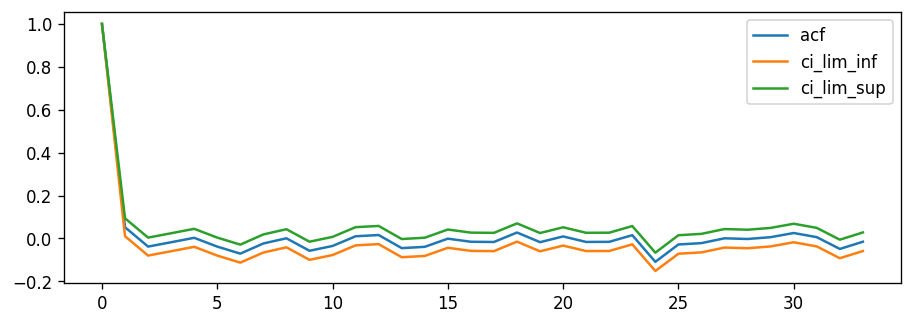

In [346]:
endog = df_serie_temporal['windspeed'].diff(periods=periods).dropna().values
acf, ci = sm.tsa.acf(endog, alpha=0.05)
pacf, ci2 = sm.tsa.pacf(endog, alpha=0.05)
df_acf = pd.concat([pd.DataFrame(data=acf, columns=['acf']), pd.DataFrame(data=ci, columns=['ci_lim_inf', 'ci_lim_sup'])],
                   axis=1)
df_acf['significative'] = ~df_acf['acf'].between(-1.96/np.sqrt(len(endog)), 1.96/np.sqrt(len(endog)))
df_acf.plot()
df_acf

,pacf,ci2_lim_inf,ci2_lim_sup,significative
0,1.000000,1.000000,1.000000,True
1,0.052343,0.010623,0.094063,True
2,-0.040617,-0.082337,0.001103,False
3,-0.013393,-0.055114,0.028327,False
4,0.003288,-0.038433,0.045008,False
5,-0.039619,-0.081339,0.002101,False
6,-0.066992,-0.108712,-0.025272,True
7,-0.019131,-0.060851,0.022589,False
8,-0.003526,-0.045246,0.038194,False
9,-0.061800,-0.103521,-0.020080,True


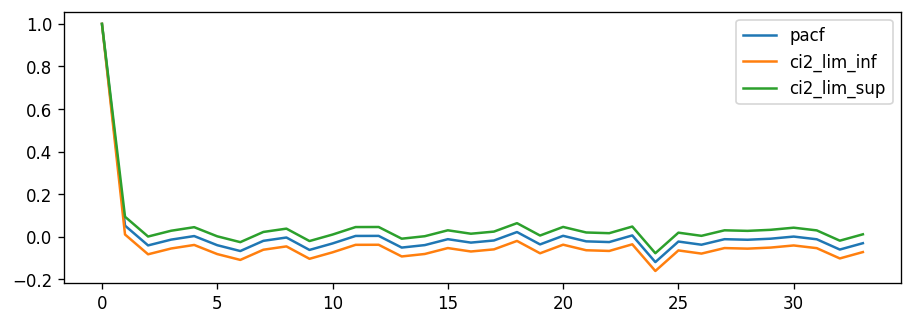

In [347]:
df_pacf = pd.concat([pd.DataFrame(data=pacf, columns=['pacf']), pd.DataFrame(data=ci2, columns=['ci2_lim_inf', 'ci2_lim_sup'])],
                   axis=1)
df_pacf['significative'] = ~df_pacf['pacf'].between(-1.96/np.sqrt(len(endog)), 1.96/np.sqrt(len(endog)))
df_pacf.plot()
df_pacf

In [350]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_serie_temporal, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

model2 = ARIMA(df_serie_temporal, order=(0,1,2))
model2_fit = model2.fit()
print(model2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              windspeed   No. Observations:                 2208
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -3818.420
Date:                Fri, 07 Oct 2022   AIC                           7642.841
Time:                        11:28:59   BIC                           7659.939
Sample:                    10-01-2018   HQIC                          7649.088
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0545      0.019      2.928      0.003       0.018       0.091
ar.L2         -0.0407      0.022     -1.863      0.063      -0.083       0.002
sigma2         1.8634      0.018    100.780      0.0

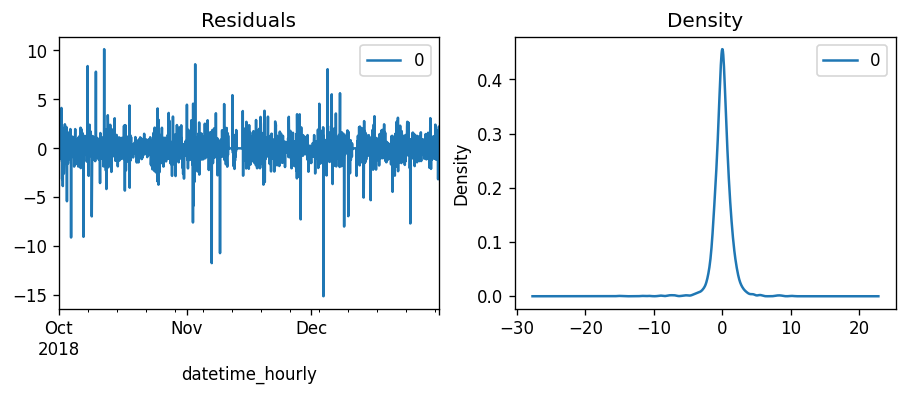

In [397]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

,lb_stat,lb_pvalue
1,0.011768,0.913615
2,0.012698,0.993671
3,0.523885,0.913613
4,0.524247,0.971098
5,3.271381,0.658226
6,13.402836,0.037067
7,14.645153,0.040827
8,14.653580,0.066242
9,21.761625,0.009666
10,23.900911,0.007868


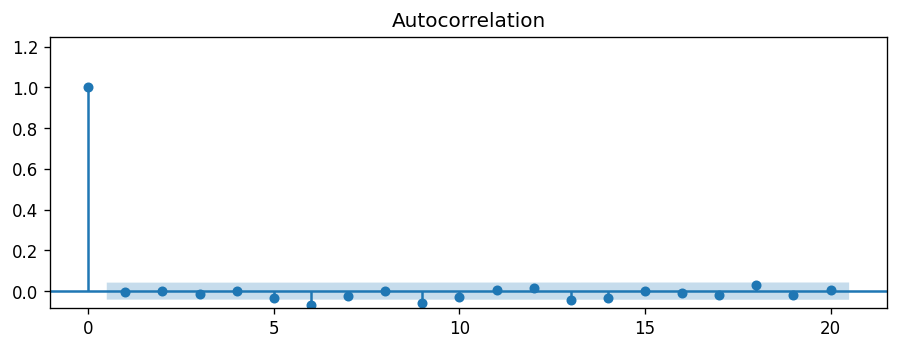

In [398]:
plot_acf(residuals, lags=20, auto_ylims=True, alpha=.05)

sm.stats.acorr_ljungbox(residuals.rename(columns={0:'res'})['res'], lags=None)
# se p_value > 0.05 não há correlação entre os pontos (portmanteau test) indicando white noise

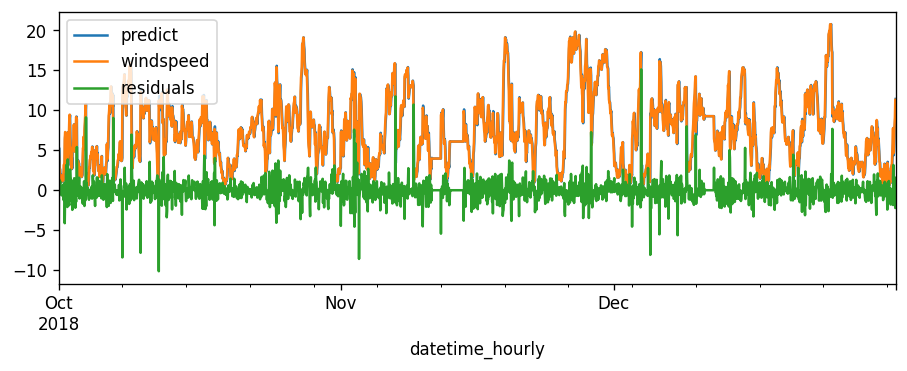

In [355]:
# Actual vs Fitted
fig, ax = plt.subplots()
model_fit.predict().plot(ax=ax, label='predict')
df_serie_temporal.plot(ax=ax, label='windspeed')

df_manual_predict = pd.concat([model_fit.predict(), df_serie_temporal], axis=1)
df_manual_predict['residuals'] = df_manual_predict['predicted_mean'] - df_manual_predict['windspeed']
df_manual_predict['residuals'].plot(ax=ax, label='residuals')
plt.legend()

In [356]:
df_serie_temporal.tail()

,windspeed
datetime_hourly,
2018-12-31 19:00:00,6.483333
2018-12-31 20:00:00,8.083333
2018-12-31 21:00:00,9.121667
2018-12-31 22:00:00,11.340000
2018-12-31 23:00:00,9.855000


<AxesSubplot:>

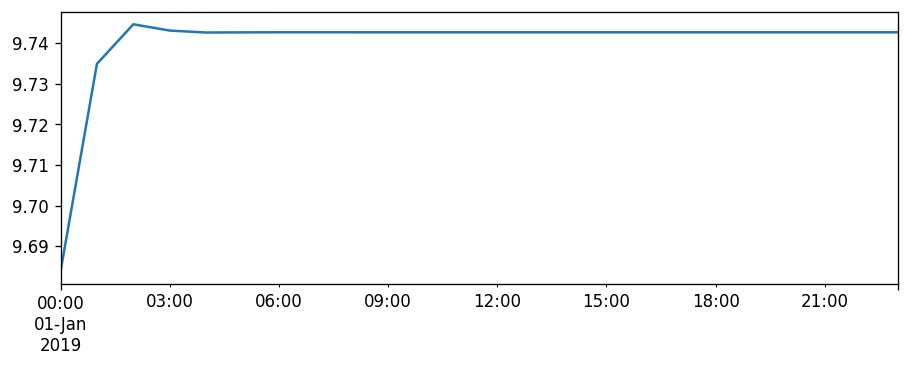

In [357]:
model_fit.forecast(steps=24).plot()

In [358]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df_serie_temporal, start_p=1, start_q=1,
                         test='kpss',
                         max_p=3, max_q=3, m=1,
                         start_P=0, seasonal=False,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7646.471, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7650.537, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7646.484, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7645.982, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7648.542, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7645.161, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=7646.105, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.43 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7643.166, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7643.986, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=7644.110, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7644.476, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2208
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -3818.583
Date:                Fri, 07 Oct 2022   AIC                           7643.166
Time:                        11:37:34   BIC                           7660.264
Sample:                             0   HQIC                          7649.413
                               - 2208                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0532      0.019      2.850      0.004       0.017       0.090
ma.L2         -0.0357      0.022     -1.636      0.102      -0.079       0.007
sigma2         1.8637      0.018    100.744      0.000       1.827       1.900
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             32556.45
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -1.16
Prob(H) (two-sided):                  0.64   Kurtosis:                        21.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [372]:
n_predict = 24
# Create Training and Test
train = df_serie_temporal[:-n_predict]
test = df_serie_temporal[-n_predict:]

In [373]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='kpss',
                         max_p=3, max_q=3, m=8,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[8] intercept   : AIC=inf, Time=5.38 sec
 ARIMA(0,0,0)(0,1,0)[8] intercept   : AIC=11951.641, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[8] intercept   : AIC=8346.738, Time=1.07 sec
 ARIMA(0,0,1)(0,1,1)[8] intercept   : AIC=9900.314, Time=2.88 sec
 ARIMA(0,0,0)(0,1,0)[8]             : AIC=11949.642, Time=0.15 sec
 ARIMA(1,0,0)(0,1,0)[8] intercept   : AIC=8912.327, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[8] intercept   : AIC=8202.409, Time=2.21 sec
 ARIMA(1,0,0)(2,1,1)[8] intercept   : AIC=inf, Time=10.70 sec
 ARIMA(1,0,0)(1,1,1)[8] intercept   : AIC=inf, Time=4.74 sec
 ARIMA(0,0,0)(2,1,0)[8] intercept   : AIC=11817.419, Time=1.33 sec
 ARIMA(2,0,0)(2,1,0)[8] intercept   : AIC=8176.072, Time=3.13 sec
 ARIMA(2,0,0)(1,1,0)[8] intercept   : AIC=8313.468, Time=1.38 sec
 ARIMA(2,0,0)(2,1,1)[8] intercept   : AIC=inf, Time=12.76 sec
 ARIMA(2,0,0)(1,1,1)[8] intercept   : AIC=inf, Time=5.66 sec
 ARIMA(3,0,0)(2,1,0)[8] intercept   : AIC=8175.211, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2184
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 8)   Log Likelihood               -4061.796
Date:                            Fri, 07 Oct 2022   AIC                           8135.592
Time:                                    12:30:16   BIC                           8169.704
Sample:                                         0   HQIC                          8148.064
                                           - 2184                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8997      0.010    190.221      0.000       1.880       1.919
ar.L2         -0.9098      0.010    -94.693      0.000      -0.929      -0.891
ma.L1         -0.9679      0.009   -104.072      0.000      -0.986      -0.950
ar.S.L8       -0.6077      0.012    -49.110      0.000      -0.632      -0.583
ar.S.L16      -0.2455      0.010    -25.490      0.000      -0.264      -0.227
sigma2         2.4426      0.041     58.914      0.000       2.361       2.524
===================================================================================
Ljung-Box (L1) (Q):                   7.19   Jarque-Bera (JB):             14020.14
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.46
Prob(H) (two-sided):                  0.30   Kurtosis:                        15.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

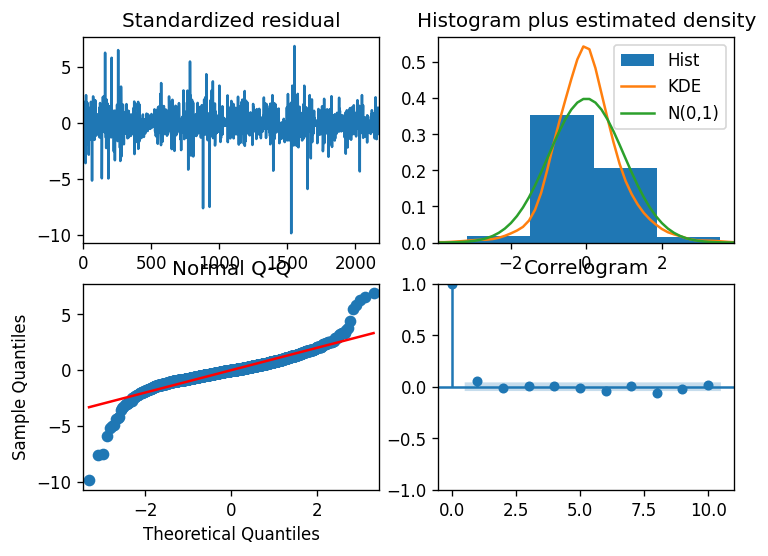

In [374]:
smodel.plot_diagnostics(figsize=(7,5))
plt.show()

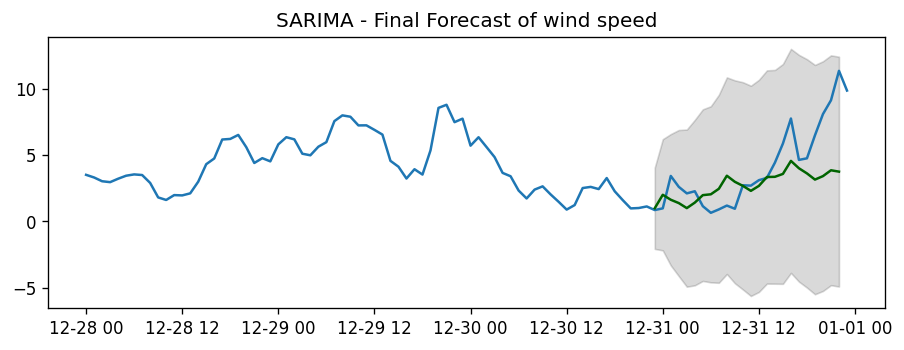

In [438]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='1H')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_serie_temporal[-96:], label='original data')
plt.plot(fitted_series, color='darkgreen', label='forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of wind speed")
plt.show()

In [378]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    from statsmodels.tsa.stattools import acf
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual.T)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf((forecast-actual)[0])[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax, 'accuracy': 1-mape})

In [379]:
forecast_accuracy(fitted, test.values)

{'mape': 0.8374943486462003,
 'me': -1.447633469886003,
 'mae': 2.6163853874941734,
 'mpe': 0.24254151830590123,
 'rmse': 3.520506748183132,
 'acf1': 0.7846200615461812,
 'corr': 0.6670550218961031,
 'minmax': 0.3850104535931643,
 'accuracy': 0.16250565135379968}

In [386]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
data = df_serie_temporal['windspeed'].values
# fit model
model_sarimax = SARIMAX(data, order=(2, 1, 0), seasonal_order=(2, 1, 0, 24))
model_sarimax_fit = model_sarimax.fit(disp=False)
# make prediction
yhat = model_sarimax_fit.predict(len(data), len(data)+10)
print(yhat)

[ 9.12194117 10.14455563  9.56959817  8.76968846  8.18715284  8.02617111
  7.50473115  7.74884043  8.2670057   8.30432887  8.17536255]


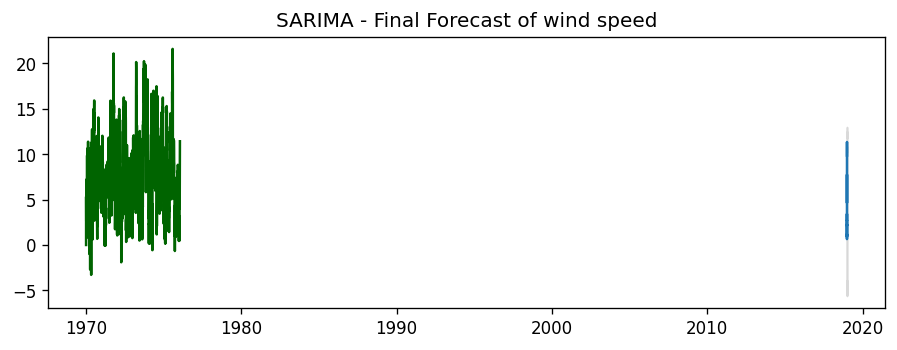

In [409]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='1H')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_serie_temporal[-96:], label='original data')
plt.plot(fitted_series, color='darkgreen', label='forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of wind speed")
plt.show()

C:\Users\renat\AppData\Local\Temp\ipykernel_42040\3866516779.py:3: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  pred1 = ExponentialSmoothing(np.asarray(train['windspeed']), trend='additive', damped=False, seasonal='additive',



== Holt-Winters Additive ETS(A,A,A) Parameters ==

Smoothing Level:  1.0
Smoothing Slope:  0.0
Smoothing Seasonal:  0.0
Initial Level:  4.8322
Initial Slope:  -0.0021
Initial Seasons:  [0.4805 0.3832 0.3079 0.2433 0.2718 0.393  0.5325 0.5544]

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2184
Model:             ExponentialSmoothing   SSE                           4071.835
Optimized:                         True   AIC                           1384.492
Trend:                         Additive   BIC                           1452.759
Seasonal:                      Additive   AICC                          1384.685
Seasonal Periods:                     8   Date:                 Mon, 10 Oct 2022
Box-Cox:                          False   Time:                         09:14:00
Box-Cox Coeff.:                    None                                         
                          

<AxesSubplot:xlabel='datetime_hourly'>

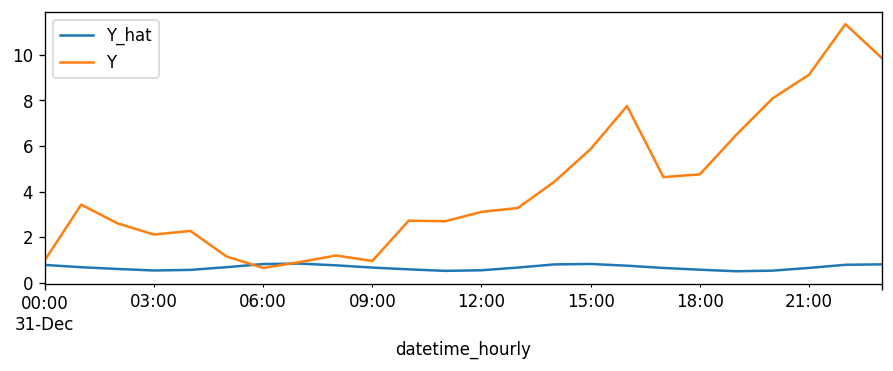

In [435]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

pred1 = ExponentialSmoothing(np.asarray(train['windspeed']), trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 8).fit() #[:'2017-01-01']
print('')
print('== Holt-Winters Additive ETS(A,A,A) Parameters ==')
print('')
alpha_value = np.round(pred1.params['smoothing_level'], 4)
print('Smoothing Level: ', alpha_value)
print('Smoothing Slope: ', np.round(pred1.params['smoothing_trend'], 4))
print('Smoothing Seasonal: ', np.round(pred1.params['smoothing_seasonal'], 4))
print('Initial Level: ', np.round(pred1.params['initial_level'], 4))
print('Initial Slope: ', np.round(pred1.params['initial_trend'], 4))
print('Initial Seasons: ', np.round(pred1.params['initial_seasons'], 4))
print('')
print(pred1.summary())

### Forecast for next 16 months

y_pred1 =  pred1.forecast(steps = 24)
df_pred1 = pd.DataFrame({'Y_hat':y_pred1,'Y':test['windspeed']})
print(df_pred1)
df_pred1.plot()